# testing outlier detection methods

## we test 4 different outlier detecton methods

- Magnitude of displacement
- Local Outlier Factor (LOF)
- Hierarchical Density Based Spatial Clustering for Applicationws with Noise (HDBSCAN)
- Global Local Outlier Score base on Hierarchies (GLOSH)

## we use 3 image pairs with varying baseline to test for robustness;

- 2020-09-27 -> 2020-11-13 B_perp = 4 m , B_temp = 47 days
- 2020-09-26 -> 2020-11-13 B_perp = 631 m , B_temp = 48 days
- 2020-09-27 -> 2021-08-12 B_perp = 1 m , B_temp = 319 days

## To get the optimal parameters, we test over different values for:

- LOF
    - k-nearest neighbours (smaller number -> local outliers, larger number -> global outliers)
- HDBSCAN
    - Minimum cluster size (larger minimum cluster size = more points labeled as outliers)
    - Minimum samples (similar to k-nearest neighbours) - smaller values means clusters get combined more often, smaller values -> fewer outliers
- GLOSH
    - Minimum samples (similar to k-nearest neighbours) - smaller values means clusters get combined more often, smaller values -> fewer outliers
    - Minimum cluster size (does not control the creation of the dendrogram but minimum samples cannot go beyond minimum cluster size.)

## we aim to use tested based on performance statistics from manually labeled data
    - ROC curves
    - area under the curve values
    - precision, recall, F-1 score
    

In [1]:
# import external packages
import numpy as np
import pandas as pd
import numba
from numba import vectorize
import glob # for file search
import copy
import os # operating system stuff
import re # regex
import fastparquet # fast read/write for large data structures
import sklearn.preprocessing as pre # for data normalisation
from sklearn.metrics import pairwise_distances

import geopandas as gpd
import rasterio as rio
import rasterio.mask
from rasterio.plot import plotting_extent
from shapely.geometry import Polygon
from shapely.geometry.point import Point
import pyproj
from pyproj import CRS
from inpoly import inpoly2 # for fast inpolygon checks
import utm


import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
from matplotlib import cm as mpl_cm
from matplotlib import colors as mcolors 

from mpl_toolkits.axes_grid1 import make_axes_locatable # for colorbar scaling
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FormatStrFormatter

import seaborn as sns
from matplotlib import rc_file_defaults
rc_file_defaults()
# sns.set(style=None, color_codes=True)



from shapely.geometry import Polygon
from shapely.geometry.point import Point
import datetime

import configparser

from cmcrameri import cm # for scientific colourmaps

###########################
# import main local package
import SPOTSAR_main as sm


In [2]:
################ Define user INPUTS #######################
######## please edit the values of this block only ########
###########################################################

# define hillshade file
HS_FILE = './test_data/DEM/TDX_Merapi_WGS84_HS.tif'

# define lon and lat files
LON_FILE = './test_data/CSK_dsc/geo2/20200910.lon'
LAT_FILE = './test_data/CSK_dsc/geo2/20200910.lat'

# define parameter text file
PARAM_FILE = './test_data/CSK_dsc/params.txt'

# define map region of interest
lon_lims = [110.425, 110.45]
lat_lims = [-7.555, -7.535]

# define colour range {min max} (min = -max)
vmax = 3 # range of colourscale in meters

# define file names for data, lon and lat
DIRECTORY_PATH = "./test_data/CSK_dsc/DISP_txt2/"
# define path to ccp and ccs files
DIRECTORY_PATH_CCS = "./test_data/CSK_dsc/CCS2/"

# Set the regular expression pattern to match the file names
PATTERN1 = r"^c20200927_c20201113_disp_[0-9]+_[0-9]+\.txt$"
PATTERN2 = r"^c20200926_c20201113_disp_[0-9]+_[0-9]+\.txt$"
PATTERN3 = r"^c20200927_c20210812_disp_[0-9]+_[0-9]+\.txt$"

# Set the regular expression pattern to match the ccs file names
PATTERN_CCS1 = r"^c20200927_c20201113_ccs_[0-9]+_[0-9]+$"
PATTERN_CCS2 = r"^c20200926_c20201113_ccs_[0-9]+_[0-9]+$"
PATTERN_CCS3 = r"^c20200927_c20210812_ccs_[0-9]+_[0-9]+$"




In [3]:

# reorder file using Post_processing.reorder_files
matching_files1 = sm.Post_processing.reorder_files(DIRECTORY_PATH,PATTERN1,0)
matching_files_ccs1 = sm.Post_processing.reorder_files(DIRECTORY_PATH_CCS,PATTERN_CCS1,0)
matching_files2 = sm.Post_processing.reorder_files(DIRECTORY_PATH,PATTERN2,0)
matching_files_ccs2 = sm.Post_processing.reorder_files(DIRECTORY_PATH_CCS,PATTERN_CCS2,0)
matching_files3 = sm.Post_processing.reorder_files(DIRECTORY_PATH,PATTERN3,0)
matching_files_ccs3 = sm.Post_processing.reorder_files(DIRECTORY_PATH_CCS,PATTERN_CCS3,0)


# test if file ordering has worked
print(matching_files1)
print(matching_files_ccs1)
print(matching_files2)
print(matching_files_ccs2)
print(matching_files3)
print(matching_files_ccs3)

['c20200927_c20201113_disp_58_28.txt', 'c20200927_c20201113_disp_140_68.txt', 'c20200927_c20201113_disp_224_108.txt', 'c20200927_c20201113_disp_306_148.txt', 'c20200927_c20201113_disp_388_188.txt']
['c20200927_c20201113_ccs_58_28', 'c20200927_c20201113_ccs_140_68', 'c20200927_c20201113_ccs_224_108', 'c20200927_c20201113_ccs_306_148', 'c20200927_c20201113_ccs_388_188']
['c20200926_c20201113_disp_58_28.txt', 'c20200926_c20201113_disp_140_68.txt', 'c20200926_c20201113_disp_224_108.txt', 'c20200926_c20201113_disp_306_148.txt', 'c20200926_c20201113_disp_388_188.txt']
['c20200926_c20201113_ccs_58_28', 'c20200926_c20201113_ccs_140_68', 'c20200926_c20201113_ccs_224_108', 'c20200926_c20201113_ccs_306_148', 'c20200926_c20201113_ccs_388_188']
['c20200927_c20210812_disp_58_28.txt', 'c20200927_c20210812_disp_140_68.txt', 'c20200927_c20210812_disp_224_108.txt', 'c20200927_c20210812_disp_306_148.txt', 'c20200927_c20210812_disp_388_188.txt']
['c20200927_c20210812_ccs_58_28', 'c20200927_c20210812_ccs_1

In [4]:
# open hillshade file and re-order offset and CCS files

# open hill shade file with rasterio
DEM_HS = rio.open(HS_FILE)
SHADING = DEM_HS.read(1,masked=True) # rasterio bands are indexed from 1

# extract DEM extent
DEM_EXTENT=[DEM_HS.bounds.left,DEM_HS.bounds.right,DEM_HS.bounds.bottom,DEM_HS.bounds.top]


In [5]:
# read parameters from text file
config = configparser.ConfigParser()
config.read(PARAM_FILE)
WIDTH = int(config.get('params', 'width'))
LINES = int(config.get('params', 'lines'))
WIDTH_CCS = int(config.get('params', 'width_ccs'))
LINES_CCS = int(config.get('params', 'lines_ccs'))
R_START = int(config.get('params', 'r_start'))
A_START = int(config.get('params', 'a_start'))
R_STEP = int(config.get('params', 'r_step'))
A_STEP = int(config.get('params', 'a_step'))
HEADING = float(config.get('params', 'heading'))
MEAN_INC = float(config.get('params', 'mean_inc'))

In [6]:

# load data from files into class multi-kernel
example_pairs = []
for (matching_files,matching_files_ccs) in zip([matching_files1,matching_files2,matching_files3],[matching_files_ccs1,matching_files_ccs2,matching_files_ccs3]):
    datastack = sm.Post_processing.MultiKernel(DIRECTORY_PATH,
                                            matching_files,
                                            DIRECTORY_PATH_CCS,
                                            matching_files_ccs,
                                            LAT_FILE,
                                            LON_FILE,
                                            HEADING,
                                            MEAN_INC,
                                            LINES_CCS,
                                            WIDTH_CCS)
    # We need to assign some data not stored in the disp.txt files.
    datastack.get_params_from_file_name()
    datastack.get_latlon_from_file(WIDTH)
    datastack.add_lat_lon_to_data(R_START,A_START)
    datastack.crop_stack_ccs(R_STEP,A_STEP)
    # the object datastack now has several attributes associated with the whole dataset (e.g., date1, date2, heading)
    # Next we add all the offset data (disp.txt) to the stack
    stacked_data = datastack.assign_data_to_stack(R_STEP,A_STEP)
    # The attribute 'Stack' we find a list of single-kernel objects which contain the actual offset data, ccp and ccs data and the coordinates.

    # add stack to list
    example_pairs.append(datastack)



In [7]:
%matplotlib osx
# print vector field
test_obj = example_pairs[0].Stack[2]
# sm.plot.plot_vec_attr(test_obj,'Phase',10,50,[0,360],1,shading,DEM_extent)
sm.plot.plot_vec_attr(test_obj,'Phase',2,50,0.005,[0,360],5,SHADING,DEM_EXTENT,[-7.55, -7.53],[110.43,110.46])


(<Figure size 1600x1600 with 2 Axes>,
 <Axes: title={'center': 'Phase: min = 0.0007761827936008103 max = 359.9995921165904'}>)

In [8]:
plt.close('all')

In [9]:
# ##get query point statisitcs before outlier removal

# # query points
# q1 = [110.446216,-7.536389] # stable no veg north
# q2 = [110.42647,-7.53297] # stable veg north west
# q3 = [110.4421429,-7.5377992] # L1888
# q4 = [110.44214,-7.54237] # L1998 large disp
# q5 = [110.44013,-7.54678] # stable no veg south
# q6 = [110.44200,-7.53604] # L1956 offset gradient
# query_points = np.stack((q1,q2,q3,q4,q5,q6))
# r = 50

# indeces = [0,2,4,6]
# stats_list, coordinate_circles = datastack.query_point_stack('R_off_vec',
#                                                              query_points[:,1],
#                                                              query_points[:,0],
#                                                              r,
#                                                              indeces)

# print(stats_list)

### manually labeling outliers
We give each point the following handles:

- 0: singular outlier
- 1: grouped outlier
- 2: inlier no def
- 3: inlier def

We also label each data point as either low or high confidence

We manually label about 400 randomly selected points from each image pair and each window size.


In [10]:
# todo
# pair 1: 0 1 2 3 4
# pair 2: 0 1 2 3 4
# pair 3: 0 1 2 3 4
# note: unill new run finishes, 0 is not reliable, 1 does not exist and 2,3,4 are indexed 1,2,3
# todo
# pair 1: 
# pair 2: 0 1 
# pair 3: 0 1 
import random
import csv
from IPython.display import clear_output
N_test = 400
test_obj = example_pairs[0].Stack[0]
# get set of random integers for dataset testing:
idx_rand = [random.randint(0,np.size(test_obj.R_off_vec)) for i in range(N_test)]
print(test_obj.R_win, test_obj.A_win)

col_ids = getattr(test_obj,'Col_index_vec')
row_ids = getattr(test_obj,'Row_index_vec')

mask = (col_ids>=500) & (col_ids<=800) & (row_ids>=100) & (row_ids<=450) & (np.mod(col_ids,10)==0) & (np.mod(row_ids,10)==0)
idx_rand = np.argwhere(mask)
# print(row_ids[mask])

58 28


<Figure size 640x480 with 0 Axes>

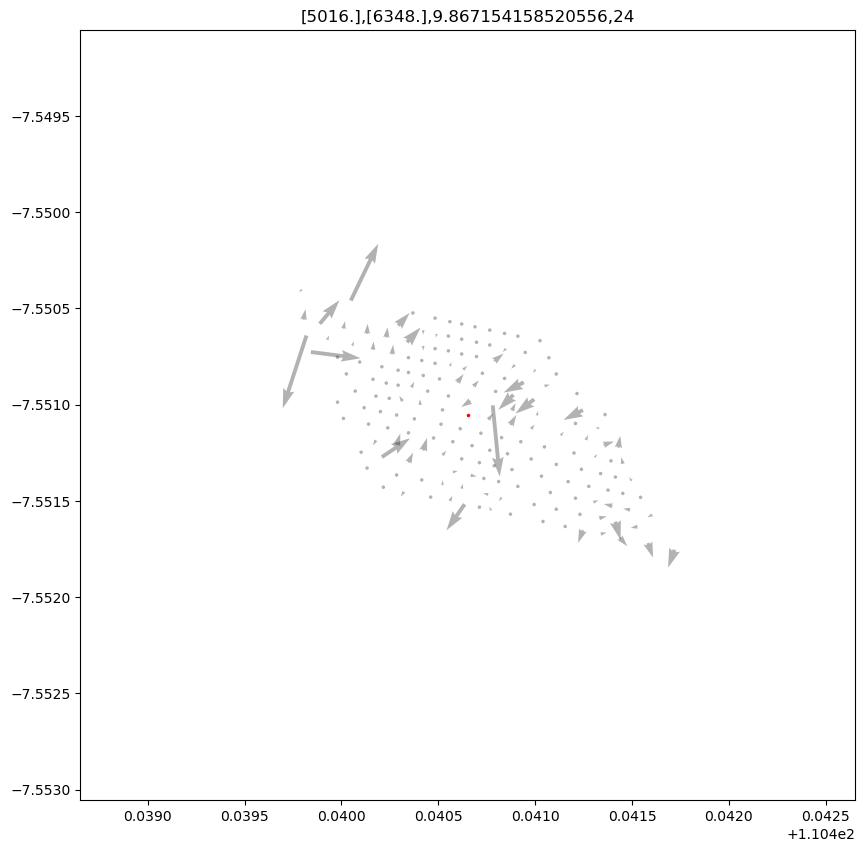

ValueError: invalid literal for int() with base 10: ''

In [12]:
%matplotlib inline
# manually check many different vectors to classify as outlier, inlier and confidence on deformation

## make testing data0002
# store R_idx, A_idx, in/out flag, def flag
# outlier flag:
# 0: singular outlier
# 1: grouped outlier
# 2: def not mov0000ing03002
# 3: def moving

# confidence flag:
# 0: high
# 1: low



test_file = f'./test_data/CSK_dsc/{test_obj.Name[0:-4]}_test_set4.csv'
wL2_thresh = 16
init_csv = int(input('initialize csv file?'))

# writing to csv file 
if init_csv == 1:
    with open(test_file, 'w') as csvfile: 
        # creating a csv writer object 
        csvwriter = csv.writer(csvfile) 
            
        # writing the fields 
        csvwriter.writerow(['R idx', 'A idx', 'in/out flag', 'def flag']) 

test_data = []
counter = 1
counter_start = 158
for idx in idx_rand:
    if counter<=counter_start:
        counter+=1
        continue
    if np.mod(counter,10)==0:
        test_data_df = pd.DataFrame(test_data)
        test_data_df.to_csv(test_file, mode='a', index=False, header=False)
        test_data = []
    sm.plot.plot_rand_vec_skip(test_obj,idx,5,0.002,0.3,2,wL2_thresh)
    plt.show(block=False)
    in_out_flag = int(input('what is the in/out flag? 0: singular outlier, 1: grouped outlier,  2: inlier not moving, 3: inlier moving'))
    if in_out_flag not in [0,1,2,3]:
        print('ERROR: flag needs to be 0, 1, 2, or 3')
        print(f'counter: {counter}')
        break
    def_flag = int(input('what is the conf flag? 0: high conf, 1: low conf'))
    if def_flag not in [0,1]:
        print('ERROR: flag needs to be 0, 1')
        print(f'counter: {counter}')
        break
    test_data.append([test_obj.R_idx_vec[idx][0], test_obj.A_idx_vec[idx][0], in_out_flag, def_flag])
    plt.clf()
    clear_output(wait=True)
    counter += 1

test_data = pd.DataFrame(test_data)
test_data.to_csv(test_file, mode='a', index=False, header=False)

In [ ]:
plt.close('all')

In [ ]:
test_data.append([test_obj.R_idx_vec[idx][0], test_obj.A_idx_vec[idx][0], in_out_flag, def_flag])
# plt.clf()
# clear_output(wait=True)
# counter += 1

test_data = pd.DataFrame(test_data)
test_data.to_csv(test_file, mode='a', index=False, header=False)

## check outlier detection via confusion matrix

Plot ROC curves for each method:
- magnitude
- LOF
- GLOSH
- HDBSCAN

for LOF, GLOSH and HDBSCAN vary k neierest neighbors/ min cluster size

for HDBSCAN and GLOSH vary min samples


In [10]:
# Perform HDBSCAN and LOF for different window sizes and different values of min cluster size
import time
import h5py

def outlier_detection_HDBSCAN(stack,N_overlap,min_samples_fact,start,hard_lim,h5_file):
    HDBSCAN_list = []
    GLOSH_list = []

    for obj in stack:
        overlap = np.ceil((obj.R_win/R_STEP) * (obj.A_win/A_STEP))
        print(f'current window size: {obj.R_win}, {obj.A_win}, overlap: {overlap}')
        hard_limit = hard_lim
        min_cluster_size = np.max([int(np.round(N_overlap*overlap)),hard_limit])
        min_samples = np.max([1,int(np.round(min_cluster_size*min_samples_fact))])
        print(f'min cluster size: {min_cluster_size}')
        print(f'min samples: {min_samples}')
        # normalize data 
        obj.prep_DBSCAN(1,1,100)
        # perform PCA (does not do much)
        obj.run_PCA(4)
        # run HDBSCAN + GLOSH
        f = h5py.File(h5_file,'a')
        if f'HDBSCAN_labels_{int(min_cluster_size)}_{int(min_samples)}_vec' not in f:
            f.close()
            HDBSCAN_labels, GLOSH_probabilities, HDBSCAN_probabilities = obj.run_HDBSCAN(int(min_cluster_size),int(min_samples),False,0.0)
            HDBSCAN_list.append( HDBSCAN_probabilities)
            GLOSH_list.append(GLOSH_probabilities)
            obj.to_hdf5(h5_file,[f'HDBSCAN_labels_{int(min_cluster_size)}_{int(min_samples)}_vec',
                                f'HDBSCAN_outlier_scores_{int(min_cluster_size)}_{int(min_samples)}_vec',
                                f'HDBSCAN_probabilities_{int(min_cluster_size)}_{int(min_samples)}_vec',
                                f'HDBSCAN_labels_{int(min_cluster_size)}_{int(min_samples)}',
                                f'HDBSCAN_outlier_scores_{int(min_cluster_size)}_{int(min_samples)}',
                                f'HDBSCAN_probabilities_{int(min_cluster_size)}_{int(min_samples)}'])

        
        print(f'time: {time.time()-start}')
    return HDBSCAN_list, GLOSH_list


def outlier_detection_LOF(stack,N_overlap,start,hard_lim,h5_file):
    LOF_list = []
    for obj in stack:
        print(f'current window size: {obj.R_win}, {obj.A_win}')
        # get overlap
        overlap = np.ceil((obj.R_win/R_STEP) * (obj.A_win/A_STEP))
        hard_limit = hard_lim
        min_cluster_size = np.max([int(N_overlap*overlap),hard_limit])
        print(f'knn: {min_cluster_size}')
        # normalize data 
        obj.prep_DBSCAN(1,1,100)
        # perform PCA (does not do much)
        obj.run_PCA(4)
        # run LOF
        f = h5py.File(h5_file,'a')
        if f'LOF_labels_{int(min_cluster_size)}_vec' not in f:
            f.close()
            LOF_labels, LOF_negative_score = obj.run_LOF(n_neighbors=int(min_cluster_size),algorithm='auto',leaf_size=30,contamination='auto')
            
            obj.to_hdf5(h5_file,[f'LOF_labels_{int(min_cluster_size)}_vec',
                                f'LOF_outlier_score_{int(min_cluster_size)}_vec',
                                f'LOF_labels_{int(min_cluster_size)}',
                                f'LOF_outlier_scores_{int(min_cluster_size)}'])
            
            LOF_list.append(LOF_negative_score)


        print(f'time: {time.time()-start}')
    return LOF_list




In [ ]:
plt.close('all')

In [11]:

print(example_pairs[0].Stack[2].Name)
obj = example_pairs[0].Stack[2]
print(dir(obj))

c20200927_c20201113_disp_224_108.txt
['A_idx', 'A_idx_vec', 'A_off', 'A_off_vec', 'A_win', 'Ccp_off', 'Ccp_off_vec', 'Ccs_off', 'Ccs_off_vec', 'Col_index', 'Col_index_vec', 'Date1', 'Date2', 'Heading', 'Lat_off', 'Lat_off_vec', 'Lon_off', 'Lon_off_vec', 'Mag', 'Mag_vec', 'Name', 'Nan_mask', 'Nan_mask_vec', 'Phase', 'Phase_vec', 'R_idx', 'R_idx_vec', 'R_off', 'R_off_vec', 'R_win', 'Row_index', 'Row_index_vec', 'SNR', 'SNR_vec', 'X_off', 'X_off_vec', 'Y_off', 'Y_off_vec', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'calc_Mag', 'calc_SNR', 'calc_local_L2', 'calc_phase', 'comp_ll_dist_matrix', 'from_hdf5', 'get_Row_Col_vec', 'get_Row_col_idx', 'get_attr_list', 'get_coords', 'get_data', 'get_data

In [18]:
# run outlier detection for several k-nn values
import time
HDBSCAN_list = []
GLOSH_list = []
LOF_list = []
N_overlap = [0.1, 0.5 ,1, 2, 4, 8, 16, 32]
min_samples_facts = [0.00001, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
hard_lim = 16 # do not compute min_cluster values below this limit
objs = [example_pairs[0].Stack[2]]
h5_file = f'./test_data/CSK_dsc/hdf5_files/{objs[0].Name[0:-4]}_outlier_detected2.h5'
start = time.time()
for N_over in N_overlap:
    for min_samples_fact in min_samples_facts:
        print(f'N overlap: {N_over} min_samples: {min_samples_fact}')
        print('do HDBSCAN')
        HDBSCAN_probs, GLOSH_probs = outlier_detection_HDBSCAN(objs,N_over,min_samples_fact,start,hard_lim,h5_file)
        HDBSCAN_list.append(HDBSCAN_probs)
        GLOSH_list.append(GLOSH_probs)
    print('do LOF')
    LOF_score = outlier_detection_LOF(objs,N_over,start,hard_lim,h5_file)
    LOF_list.append(LOF_score)


# # objs = [example_pairs[0].Stack[1]]

# # save_keys = ['R_idx','A_idx','Row_index','Col_index','Lon_off','Lat_off','R_off','A_off']
# for obj in objs:
#     save_keys = ['R_idx','A_idx','Row_index','Col_index','Lon_off','Lat_off','R_off','A_off']
#     for key in dir(obj):
#         if ('HDBSCAN' == key[0:7]) and (key[-3:] != 'vec'):
#             save_keys.append(key)
#         if ('GLOSH' == key[0:5]) and  (key[-3:] != 'vec'):
#             save_keys.append(key)
#         if ('LOF' == key[0:3]) and  (key[-3:] != 'vec'):
#             save_keys.append(key)
#     print(save_keys)
#     obj.to_hdf5(f'./test_data/CSK_dsc/hdf5_files/{obj.Name[0:-4]}_outlier_detected2.h5',save_keys)



N overlap: 0.1 min_samples: 1e-05
do HDBSCAN
current window size: 224, 108, overlap: 84.0
min cluster size: 16
min samples: 1
time: 1.82076096534729
N overlap: 0.1 min_samples: 0.1
do HDBSCAN
current window size: 224, 108, overlap: 84.0
min cluster size: 16
min samples: 2
time: 3.21807599067688
N overlap: 0.1 min_samples: 0.2
do HDBSCAN
current window size: 224, 108, overlap: 84.0
min cluster size: 16
min samples: 3
time: 4.549330949783325
N overlap: 0.1 min_samples: 0.3
do HDBSCAN
current window size: 224, 108, overlap: 84.0
min cluster size: 16
min samples: 5
time: 6.058752059936523
N overlap: 0.1 min_samples: 0.4
do HDBSCAN
current window size: 224, 108, overlap: 84.0
min cluster size: 16
min samples: 6
time: 7.582698106765747
N overlap: 0.1 min_samples: 0.5
do HDBSCAN
current window size: 224, 108, overlap: 84.0
min cluster size: 16
min samples: 8
time: 8.994485139846802
N overlap: 0.1 min_samples: 0.6
do HDBSCAN
current window size: 224, 108, overlap: 84.0
min cluster size: 16
min

In [27]:
plt.close('all')
LOF_score = outlier_detection_LOF([example_pairs[0].Stack[2]],0.00001,time.time(),16,f'./test_data/CSK_dsc/hdf5_files/{example_pairs[0].Stack[2].Name[0:-4]}_outlier_detected2.h5')

current window size: 224, 108
knn: 16
time: 16.011183738708496


In [19]:
print(dir(example_pairs[0].Stack[2]))

['A_idx', 'A_idx_vec', 'A_off', 'A_off_vec', 'A_win', 'Ccp_off', 'Ccp_off_vec', 'Ccs_off', 'Ccs_off_vec', 'Col_index', 'Col_index_vec', 'Date1', 'Date2', 'HDBSCAN_labels_1344_1', 'HDBSCAN_labels_1344_134', 'HDBSCAN_labels_1344_134_vec', 'HDBSCAN_labels_1344_1_vec', 'HDBSCAN_labels_1344_269', 'HDBSCAN_labels_1344_269_vec', 'HDBSCAN_labels_1344_403', 'HDBSCAN_labels_1344_403_vec', 'HDBSCAN_labels_1344_538', 'HDBSCAN_labels_1344_538_vec', 'HDBSCAN_labels_1344_672', 'HDBSCAN_labels_1344_672_vec', 'HDBSCAN_labels_1344_806', 'HDBSCAN_labels_1344_806_vec', 'HDBSCAN_labels_168_1', 'HDBSCAN_labels_168_101', 'HDBSCAN_labels_168_101_vec', 'HDBSCAN_labels_168_17', 'HDBSCAN_labels_168_17_vec', 'HDBSCAN_labels_168_1_vec', 'HDBSCAN_labels_168_34', 'HDBSCAN_labels_168_34_vec', 'HDBSCAN_labels_168_50', 'HDBSCAN_labels_168_50_vec', 'HDBSCAN_labels_168_67', 'HDBSCAN_labels_168_67_vec', 'HDBSCAN_labels_168_84', 'HDBSCAN_labels_168_84_vec', 'HDBSCAN_labels_16_1', 'HDBSCAN_labels_16_10', 'HDBSCAN_labels_16_

In [ ]:
# objs = [example_pairs[0].Stack[1]]

objs = [example_pairs[0].Stack[1]]
# save_keys = ['R_idx','A_idx','Row_index','Col_index','Lon_off','Lat_off','R_off','A_off']
for obj in objs:
    save_keys = ['R_idx','A_idx','Row_index','Col_index','Lon_off','Lat_off','R_off','A_off']
    for key in dir(obj):
        if ('HDBSCAN' == key[0:7]) and (key[-3:] != 'vec'):
            save_keys.append(key)
        if ('GLOSH' == key[0:5]) and  (key[-3:] != 'vec'):
            save_keys.append(key)
        if ('LOF' == key[0:3]) and  (key[-3:] != 'vec'):
            save_keys.append(key)
    print(save_keys)
    obj.to_hdf5(f'./test_data/CSK_dsc/hdf5_files/{obj.Name[0:-4]}_outlier_detected3.h5',save_keys)



In [ ]:
print(example_pairs[0].Stack[3].HDBSCAN_outlier_scores_16_1)

In [26]:

import h5py
filename = './test_data/CSK_dsc/hdf5_files/c20200927_c20201113_disp_224_108_outlier_detected2.h5'
f= h5py.File(filename,'a')
# f.__delitem__('LOF_labels_16_vec')
# f.__delitem__('LOF_labels_16')

print(f.keys())
f.close()

<KeysViewHDF5 ['HDBSCAN_labels_1344_1', 'HDBSCAN_labels_1344_134', 'HDBSCAN_labels_1344_134_vec', 'HDBSCAN_labels_1344_1_vec', 'HDBSCAN_labels_1344_269', 'HDBSCAN_labels_1344_269_vec', 'HDBSCAN_labels_1344_403', 'HDBSCAN_labels_1344_403_vec', 'HDBSCAN_labels_1344_538', 'HDBSCAN_labels_1344_538_vec', 'HDBSCAN_labels_1344_672', 'HDBSCAN_labels_1344_672_vec', 'HDBSCAN_labels_1344_806', 'HDBSCAN_labels_1344_806_vec', 'HDBSCAN_labels_168_1', 'HDBSCAN_labels_168_101', 'HDBSCAN_labels_168_101_vec', 'HDBSCAN_labels_168_17', 'HDBSCAN_labels_168_17_vec', 'HDBSCAN_labels_168_1_vec', 'HDBSCAN_labels_168_34', 'HDBSCAN_labels_168_34_vec', 'HDBSCAN_labels_168_50', 'HDBSCAN_labels_168_50_vec', 'HDBSCAN_labels_168_67', 'HDBSCAN_labels_168_67_vec', 'HDBSCAN_labels_168_84', 'HDBSCAN_labels_168_84_vec', 'HDBSCAN_labels_16_1', 'HDBSCAN_labels_16_10', 'HDBSCAN_labels_16_10_vec', 'HDBSCAN_labels_16_1_vec', 'HDBSCAN_labels_16_2', 'HDBSCAN_labels_16_2_vec', 'HDBSCAN_labels_16_3', 'HDBSCAN_labels_16_3_vec', 'HD

In [22]:
16,192,24, 384,48,96,
16,24,48,96,192
1088, 136, 16, 17, 2176, 272, 34, 544, 68,
16,17,34,68,136,272,544,1088,2176
1344, 168, 16, 2688, 336, 42, 672, 84
16,42,84,168,336,672,1344,2688
1264, 158, 16, 316, 632, 79

1016, 127, 2032, 254, 25, 508, 
n_over_facts = np.array([16,42,84,168,336,672,1344,2688])/84
print(n_over_facts)


[ 0.19047619  0.5         1.          2.          4.          8.
 16.         32.        ]


In [12]:

# save_keys = ['R_idx','A_idx','Row_index','Col_index','Lon_off','Lat_off','R_off','A_off']
# for key in dir(obj[0]):
#     if ('HDBSCAN' == key[0:7]) and (key[-3:] != 'vec'):
#         save_keys.append(key)
#     if ('GLOSH' == key[0:5]) and  (key[-3:] != 'vec'):
#         save_keys.append(key)
#     if ('LOF' == key[0:3]) and  (key[-3:] != 'vec'):
#         save_keys.append(key)
# print(save_keys)
# obj[0].to_hdf5(f'./test_data/CSK_dsc/hdf5_files/{obj[0].Name[0:-4]}_outlier_detected.h5',save_keys)
obj = example_pairs[0].Stack[2]
# f = h5py.File(f'./test_data/CSK_dsc/hdf5_files/{obj.Name[0:-4]}_outlier_detected.h5')
query_keys = ['HDBSCAN_labels_1344_1', 'HDBSCAN_labels_1344_134', 'HDBSCAN_labels_1344_134_vec', 'HDBSCAN_labels_1344_1_vec', 'HDBSCAN_labels_1344_269', 'HDBSCAN_labels_1344_269_vec', 'HDBSCAN_labels_1344_403', 'HDBSCAN_labels_1344_403_vec', 'HDBSCAN_labels_1344_538', 'HDBSCAN_labels_1344_538_vec', 'HDBSCAN_labels_1344_672', 'HDBSCAN_labels_1344_672_vec', 'HDBSCAN_labels_1344_806', 'HDBSCAN_labels_1344_806_vec', 'HDBSCAN_labels_168_1', 'HDBSCAN_labels_168_101', 'HDBSCAN_labels_168_101_vec', 'HDBSCAN_labels_168_17', 'HDBSCAN_labels_168_17_vec', 'HDBSCAN_labels_168_1_vec', 'HDBSCAN_labels_168_34', 'HDBSCAN_labels_168_34_vec', 'HDBSCAN_labels_168_50', 'HDBSCAN_labels_168_50_vec', 'HDBSCAN_labels_168_67', 'HDBSCAN_labels_168_67_vec', 'HDBSCAN_labels_168_84', 'HDBSCAN_labels_168_84_vec', 'HDBSCAN_labels_16_1', 'HDBSCAN_labels_16_10', 'HDBSCAN_labels_16_10_vec', 'HDBSCAN_labels_16_1_vec', 'HDBSCAN_labels_16_2', 'HDBSCAN_labels_16_2_vec', 'HDBSCAN_labels_16_3', 'HDBSCAN_labels_16_3_vec', 'HDBSCAN_labels_16_5', 'HDBSCAN_labels_16_5_vec', 'HDBSCAN_labels_16_6', 'HDBSCAN_labels_16_6_vec', 'HDBSCAN_labels_16_8', 'HDBSCAN_labels_16_8_vec', 'HDBSCAN_labels_2688_1', 'HDBSCAN_labels_2688_1075', 'HDBSCAN_labels_2688_1075_vec', 'HDBSCAN_labels_2688_1344', 'HDBSCAN_labels_2688_1344_vec', 'HDBSCAN_labels_2688_1613', 'HDBSCAN_labels_2688_1613_vec', 'HDBSCAN_labels_2688_1_vec', 'HDBSCAN_labels_2688_269', 'HDBSCAN_labels_2688_269_vec', 'HDBSCAN_labels_2688_538', 'HDBSCAN_labels_2688_538_vec', 'HDBSCAN_labels_2688_806', 'HDBSCAN_labels_2688_806_vec', 'HDBSCAN_labels_336_1', 'HDBSCAN_labels_336_101', 'HDBSCAN_labels_336_101_vec', 'HDBSCAN_labels_336_134', 'HDBSCAN_labels_336_134_vec', 'HDBSCAN_labels_336_168', 'HDBSCAN_labels_336_168_vec', 'HDBSCAN_labels_336_1_vec', 'HDBSCAN_labels_336_202', 'HDBSCAN_labels_336_202_vec', 'HDBSCAN_labels_336_34', 'HDBSCAN_labels_336_34_vec', 'HDBSCAN_labels_336_67', 'HDBSCAN_labels_336_67_vec', 'HDBSCAN_labels_42_1', 'HDBSCAN_labels_42_13', 'HDBSCAN_labels_42_13_vec', 'HDBSCAN_labels_42_17', 'HDBSCAN_labels_42_17_vec', 'HDBSCAN_labels_42_1_vec', 'HDBSCAN_labels_42_21', 'HDBSCAN_labels_42_21_vec', 'HDBSCAN_labels_42_25', 'HDBSCAN_labels_42_25_vec', 'HDBSCAN_labels_42_4', 'HDBSCAN_labels_42_4_vec', 'HDBSCAN_labels_42_8', 'HDBSCAN_labels_42_8_vec', 'HDBSCAN_labels_672_1', 'HDBSCAN_labels_672_134', 'HDBSCAN_labels_672_134_vec', 'HDBSCAN_labels_672_1_vec', 'HDBSCAN_labels_672_202', 'HDBSCAN_labels_672_202_vec', 'HDBSCAN_labels_672_269', 'HDBSCAN_labels_672_269_vec', 'HDBSCAN_labels_672_336', 'HDBSCAN_labels_672_336_vec', 'HDBSCAN_labels_672_403', 'HDBSCAN_labels_672_403_vec', 'HDBSCAN_labels_672_67', 'HDBSCAN_labels_672_67_vec', 'HDBSCAN_labels_84_1', 'HDBSCAN_labels_84_17', 'HDBSCAN_labels_84_17_vec', 'HDBSCAN_labels_84_1_vec', 'HDBSCAN_labels_84_25', 'HDBSCAN_labels_84_25_vec', 'HDBSCAN_labels_84_34', 'HDBSCAN_labels_84_34_vec', 'HDBSCAN_labels_84_42', 'HDBSCAN_labels_84_42_vec', 'HDBSCAN_labels_84_50', 'HDBSCAN_labels_84_50_vec', 'HDBSCAN_labels_84_8', 'HDBSCAN_labels_84_8_vec', 'HDBSCAN_outlier_scores_1344_1', 'HDBSCAN_outlier_scores_1344_134', 'HDBSCAN_outlier_scores_1344_134_vec', 'HDBSCAN_outlier_scores_1344_1_vec', 'HDBSCAN_outlier_scores_1344_269', 'HDBSCAN_outlier_scores_1344_269_vec', 'HDBSCAN_outlier_scores_1344_403', 'HDBSCAN_outlier_scores_1344_403_vec', 'HDBSCAN_outlier_scores_1344_538', 'HDBSCAN_outlier_scores_1344_538_vec', 'HDBSCAN_outlier_scores_1344_672', 'HDBSCAN_outlier_scores_1344_672_vec', 'HDBSCAN_outlier_scores_1344_806', 'HDBSCAN_outlier_scores_1344_806_vec', 'HDBSCAN_outlier_scores_168_1', 'HDBSCAN_outlier_scores_168_101', 'HDBSCAN_outlier_scores_168_101_vec', 'HDBSCAN_outlier_scores_168_17', 'HDBSCAN_outlier_scores_168_17_vec', 'HDBSCAN_outlier_scores_168_1_vec', 'HDBSCAN_outlier_scores_168_34', 'HDBSCAN_outlier_scores_168_34_vec', 'HDBSCAN_outlier_scores_168_50', 'HDBSCAN_outlier_scores_168_50_vec', 'HDBSCAN_outlier_scores_168_67', 'HDBSCAN_outlier_scores_168_67_vec', 'HDBSCAN_outlier_scores_168_84', 'HDBSCAN_outlier_scores_168_84_vec', 'HDBSCAN_outlier_scores_16_1', 'HDBSCAN_outlier_scores_16_10', 'HDBSCAN_outlier_scores_16_10_vec', 'HDBSCAN_outlier_scores_16_1_vec', 'HDBSCAN_outlier_scores_16_2', 'HDBSCAN_outlier_scores_16_2_vec', 'HDBSCAN_outlier_scores_16_3', 'HDBSCAN_outlier_scores_16_3_vec', 'HDBSCAN_outlier_scores_16_5', 'HDBSCAN_outlier_scores_16_5_vec', 'HDBSCAN_outlier_scores_16_6', 'HDBSCAN_outlier_scores_16_6_vec', 'HDBSCAN_outlier_scores_16_8', 'HDBSCAN_outlier_scores_16_8_vec', 'HDBSCAN_outlier_scores_2688_1', 'HDBSCAN_outlier_scores_2688_1075', 'HDBSCAN_outlier_scores_2688_1075_vec', 'HDBSCAN_outlier_scores_2688_1344', 'HDBSCAN_outlier_scores_2688_1344_vec', 'HDBSCAN_outlier_scores_2688_1613', 'HDBSCAN_outlier_scores_2688_1613_vec', 'HDBSCAN_outlier_scores_2688_1_vec', 'HDBSCAN_outlier_scores_2688_269', 'HDBSCAN_outlier_scores_2688_269_vec', 'HDBSCAN_outlier_scores_2688_538', 'HDBSCAN_outlier_scores_2688_538_vec', 'HDBSCAN_outlier_scores_2688_806', 'HDBSCAN_outlier_scores_2688_806_vec', 'HDBSCAN_outlier_scores_336_1', 'HDBSCAN_outlier_scores_336_101', 'HDBSCAN_outlier_scores_336_101_vec', 'HDBSCAN_outlier_scores_336_134', 'HDBSCAN_outlier_scores_336_134_vec', 'HDBSCAN_outlier_scores_336_168', 'HDBSCAN_outlier_scores_336_168_vec', 'HDBSCAN_outlier_scores_336_1_vec', 'HDBSCAN_outlier_scores_336_202', 'HDBSCAN_outlier_scores_336_202_vec', 'HDBSCAN_outlier_scores_336_34', 'HDBSCAN_outlier_scores_336_34_vec', 'HDBSCAN_outlier_scores_336_67', 'HDBSCAN_outlier_scores_336_67_vec', 'HDBSCAN_outlier_scores_42_1', 'HDBSCAN_outlier_scores_42_13', 'HDBSCAN_outlier_scores_42_13_vec', 'HDBSCAN_outlier_scores_42_17', 'HDBSCAN_outlier_scores_42_17_vec', 'HDBSCAN_outlier_scores_42_1_vec', 'HDBSCAN_outlier_scores_42_21', 'HDBSCAN_outlier_scores_42_21_vec', 'HDBSCAN_outlier_scores_42_25', 'HDBSCAN_outlier_scores_42_25_vec', 'HDBSCAN_outlier_scores_42_4', 'HDBSCAN_outlier_scores_42_4_vec', 'HDBSCAN_outlier_scores_42_8', 'HDBSCAN_outlier_scores_42_8_vec', 'HDBSCAN_outlier_scores_672_1', 'HDBSCAN_outlier_scores_672_134', 'HDBSCAN_outlier_scores_672_134_vec', 'HDBSCAN_outlier_scores_672_1_vec', 'HDBSCAN_outlier_scores_672_202', 'HDBSCAN_outlier_scores_672_202_vec', 'HDBSCAN_outlier_scores_672_269', 'HDBSCAN_outlier_scores_672_269_vec', 'HDBSCAN_outlier_scores_672_336', 'HDBSCAN_outlier_scores_672_336_vec', 'HDBSCAN_outlier_scores_672_403', 'HDBSCAN_outlier_scores_672_403_vec', 'HDBSCAN_outlier_scores_672_67', 'HDBSCAN_outlier_scores_672_67_vec', 'HDBSCAN_outlier_scores_84_1', 'HDBSCAN_outlier_scores_84_17', 'HDBSCAN_outlier_scores_84_17_vec', 'HDBSCAN_outlier_scores_84_1_vec', 'HDBSCAN_outlier_scores_84_25', 'HDBSCAN_outlier_scores_84_25_vec', 'HDBSCAN_outlier_scores_84_34', 'HDBSCAN_outlier_scores_84_34_vec', 'HDBSCAN_outlier_scores_84_42', 'HDBSCAN_outlier_scores_84_42_vec', 'HDBSCAN_outlier_scores_84_50', 'HDBSCAN_outlier_scores_84_50_vec', 'HDBSCAN_outlier_scores_84_8', 'HDBSCAN_outlier_scores_84_8_vec', 'HDBSCAN_probabilities_1344_1', 'HDBSCAN_probabilities_1344_134', 'HDBSCAN_probabilities_1344_134_vec', 'HDBSCAN_probabilities_1344_1_vec', 'HDBSCAN_probabilities_1344_269', 'HDBSCAN_probabilities_1344_269_vec', 'HDBSCAN_probabilities_1344_403', 'HDBSCAN_probabilities_1344_403_vec', 'HDBSCAN_probabilities_1344_538', 'HDBSCAN_probabilities_1344_538_vec', 'HDBSCAN_probabilities_1344_672', 'HDBSCAN_probabilities_1344_672_vec', 'HDBSCAN_probabilities_1344_806', 'HDBSCAN_probabilities_1344_806_vec', 'HDBSCAN_probabilities_168_1', 'HDBSCAN_probabilities_168_101', 'HDBSCAN_probabilities_168_101_vec', 'HDBSCAN_probabilities_168_17', 'HDBSCAN_probabilities_168_17_vec', 'HDBSCAN_probabilities_168_1_vec', 'HDBSCAN_probabilities_168_34', 'HDBSCAN_probabilities_168_34_vec', 'HDBSCAN_probabilities_168_50', 'HDBSCAN_probabilities_168_50_vec', 'HDBSCAN_probabilities_168_67', 'HDBSCAN_probabilities_168_67_vec', 'HDBSCAN_probabilities_168_84', 'HDBSCAN_probabilities_168_84_vec', 'HDBSCAN_probabilities_16_1', 'HDBSCAN_probabilities_16_10', 'HDBSCAN_probabilities_16_10_vec', 'HDBSCAN_probabilities_16_1_vec', 'HDBSCAN_probabilities_16_2', 'HDBSCAN_probabilities_16_2_vec', 'HDBSCAN_probabilities_16_3', 'HDBSCAN_probabilities_16_3_vec', 'HDBSCAN_probabilities_16_5', 'HDBSCAN_probabilities_16_5_vec', 'HDBSCAN_probabilities_16_6', 'HDBSCAN_probabilities_16_6_vec', 'HDBSCAN_probabilities_16_8', 'HDBSCAN_probabilities_16_8_vec', 'HDBSCAN_probabilities_2688_1', 'HDBSCAN_probabilities_2688_1075', 'HDBSCAN_probabilities_2688_1075_vec', 'HDBSCAN_probabilities_2688_1344', 'HDBSCAN_probabilities_2688_1344_vec', 'HDBSCAN_probabilities_2688_1613', 'HDBSCAN_probabilities_2688_1613_vec', 'HDBSCAN_probabilities_2688_1_vec', 'HDBSCAN_probabilities_2688_269', 'HDBSCAN_probabilities_2688_269_vec', 'HDBSCAN_probabilities_2688_538', 'HDBSCAN_probabilities_2688_538_vec', 'HDBSCAN_probabilities_2688_806', 'HDBSCAN_probabilities_2688_806_vec', 'HDBSCAN_probabilities_336_1', 'HDBSCAN_probabilities_336_101', 'HDBSCAN_probabilities_336_101_vec', 'HDBSCAN_probabilities_336_134', 'HDBSCAN_probabilities_336_134_vec', 'HDBSCAN_probabilities_336_168', 'HDBSCAN_probabilities_336_168_vec', 'HDBSCAN_probabilities_336_1_vec', 'HDBSCAN_probabilities_336_202', 'HDBSCAN_probabilities_336_202_vec', 'HDBSCAN_probabilities_336_34', 'HDBSCAN_probabilities_336_34_vec', 'HDBSCAN_probabilities_336_67', 'HDBSCAN_probabilities_336_67_vec', 'HDBSCAN_probabilities_42_1', 'HDBSCAN_probabilities_42_13', 'HDBSCAN_probabilities_42_13_vec', 'HDBSCAN_probabilities_42_17', 'HDBSCAN_probabilities_42_17_vec', 'HDBSCAN_probabilities_42_1_vec', 'HDBSCAN_probabilities_42_21', 'HDBSCAN_probabilities_42_21_vec', 'HDBSCAN_probabilities_42_25', 'HDBSCAN_probabilities_42_25_vec', 'HDBSCAN_probabilities_42_4', 'HDBSCAN_probabilities_42_4_vec', 'HDBSCAN_probabilities_42_8', 'HDBSCAN_probabilities_42_8_vec', 'HDBSCAN_probabilities_672_1', 'HDBSCAN_probabilities_672_134', 'HDBSCAN_probabilities_672_134_vec', 'HDBSCAN_probabilities_672_1_vec', 'HDBSCAN_probabilities_672_202', 'HDBSCAN_probabilities_672_202_vec', 'HDBSCAN_probabilities_672_269', 'HDBSCAN_probabilities_672_269_vec', 'HDBSCAN_probabilities_672_336', 'HDBSCAN_probabilities_672_336_vec', 'HDBSCAN_probabilities_672_403', 'HDBSCAN_probabilities_672_403_vec', 'HDBSCAN_probabilities_672_67', 'HDBSCAN_probabilities_672_67_vec', 'HDBSCAN_probabilities_84_1', 'HDBSCAN_probabilities_84_17', 'HDBSCAN_probabilities_84_17_vec', 'HDBSCAN_probabilities_84_1_vec', 'HDBSCAN_probabilities_84_25', 'HDBSCAN_probabilities_84_25_vec', 'HDBSCAN_probabilities_84_34', 'HDBSCAN_probabilities_84_34_vec', 'HDBSCAN_probabilities_84_42', 'HDBSCAN_probabilities_84_42_vec', 'HDBSCAN_probabilities_84_50', 'HDBSCAN_probabilities_84_50_vec', 'HDBSCAN_probabilities_84_8', 'HDBSCAN_probabilities_84_8_vec', 'LOF_labels_1344', 'LOF_labels_1344_vec', 'LOF_labels_168', 'LOF_labels_168_vec', 'LOF_labels_16_vec', 'LOF_labels_2688', 'LOF_labels_2688_vec', 'LOF_labels_336', 'LOF_labels_336_vec', 'LOF_labels_42', 'LOF_labels_42_vec', 'LOF_labels_672', 'LOF_labels_672_vec', 'LOF_labels_84', 'LOF_labels_84_vec', 'LOF_outlier_score_1344_vec', 'LOF_outlier_score_168_vec', 'LOF_outlier_score_2688_vec', 'LOF_outlier_score_336_vec', 'LOF_outlier_score_42_vec', 'LOF_outlier_score_672_vec', 'LOF_outlier_score_84_vec', 'LOF_outlier_scores_1344', 'LOF_outlier_scores_168', 'LOF_outlier_scores_2688', 'LOF_outlier_scores_336', 'LOF_outlier_scores_42', 'LOF_outlier_scores_672', 'LOF_outlier_scores_84']
obj.from_hdf5(f'./test_data/CSK_dsc/hdf5_files/{obj.Name[0:-4]}_outlier_detected2.h5',query_keys)

In [13]:
print(dir(example_pairs[0].Stack[2]))
1016, 127, 2032, 254, 25, 508,
1264, 158, 16, 316, 632, 79, 
16,42,84,168,336,672,1344,2688

['A_idx', 'A_idx_vec', 'A_off', 'A_off_vec', 'A_win', 'Ccp_off', 'Ccp_off_vec', 'Ccs_off', 'Ccs_off_vec', 'Col_index', 'Col_index_vec', 'Date1', 'Date2', 'HDBSCAN_labels_1344_1', 'HDBSCAN_labels_1344_134', 'HDBSCAN_labels_1344_134_vec', 'HDBSCAN_labels_1344_1_vec', 'HDBSCAN_labels_1344_269', 'HDBSCAN_labels_1344_269_vec', 'HDBSCAN_labels_1344_403', 'HDBSCAN_labels_1344_403_vec', 'HDBSCAN_labels_1344_538', 'HDBSCAN_labels_1344_538_vec', 'HDBSCAN_labels_1344_672', 'HDBSCAN_labels_1344_672_vec', 'HDBSCAN_labels_1344_806', 'HDBSCAN_labels_1344_806_vec', 'HDBSCAN_labels_168_1', 'HDBSCAN_labels_168_101', 'HDBSCAN_labels_168_101_vec', 'HDBSCAN_labels_168_17', 'HDBSCAN_labels_168_17_vec', 'HDBSCAN_labels_168_1_vec', 'HDBSCAN_labels_168_34', 'HDBSCAN_labels_168_34_vec', 'HDBSCAN_labels_168_50', 'HDBSCAN_labels_168_50_vec', 'HDBSCAN_labels_168_67', 'HDBSCAN_labels_168_67_vec', 'HDBSCAN_labels_168_84', 'HDBSCAN_labels_168_84_vec', 'HDBSCAN_labels_16_1', 'HDBSCAN_labels_16_10', 'HDBSCAN_labels_16_

(16, 42, 84, 168, 336, 672, 1344, 2688)

In [38]:
%matplotlib osx
import pickle
import itertools
import random

from sklearn import metrics
from matplotlib.collections import LineCollection
plt.close('all')

# plotting conditions
plotting = 0
plotting_flag = 0
labels = 0
verbose= False

# dataset to test
obj = example_pairs[0].Stack[2]

# win 0
# min_samples_facts = [0.00001, 0.1, 0.2, 0.3, 0.4, 0.5,0.6]
# min_cluster_sizes = [16,24,48,96,192,384]
# min_clust_facts = [ 2.7,4,8,16,32,64]

# win 1
# min_samples_facts = [0.00001, 0.1, 0.2, 0.3, 0.4, 0.5,0.6]
# min_cluster_sizes = [16,17,34,68,136,272,544,1088,2176]
# min_clust_facts = [0.47,0.5,1,2,4,8,16,32,64]

# win 2

min_samples_facts = [0.00001, 0.1, 0.2, 0.3, 0.4, 0.5,0.6]
min_cluster_sizes = [16,42,84,168,336,672,1344,2688]
min_clust_facts = [0.19,0.5,1,2,4,8,16,32]

# win 3
# min_samples_facts = [0.00001, 0.1, 0.2, 0.3, 0.4, 0.5,0.6]
# min_cluster_sizes = [16, 79,158,316, 632, 1264]
# min_clust_facts = [0.1,0.5,1,2,4,8]

# win 4
# min_samples_facts = [0.00001, 0.1, 0.2, 0.3, 0.4, 0.5,0.6]
# min_cluster_sizes = [25,127,254,508,1016,2032]
# min_clust_facts = [0.1,0.5,1,2,4,8]


n_cat = 100 # number of samples from each catergory of inlier/outlier
n_runs = 20 # number of runs

# make ROC plots for min cluster size vs. min samples test
fig, axes = plt.subplots(np.size(min_cluster_sizes), np.size(min_samples_facts), figsize=(20, 20))

# get data

r_win = getattr(obj, "R_win")
a_win = getattr(obj, "A_win")
r_idx = getattr(obj, "R_idx")
a_idx = getattr(obj, "A_idx")

# get testing data
test_data1 = pd.read_csv(
            f"./test_data/CSK_dsc/{obj.Name[:-4]}_test_set.csv", header=0
        ).to_numpy()
test_data2 = pd.read_csv(
            f"./test_data/CSK_dsc/{obj.Name[:-4]}_test_set3.csv", header=0
        ).to_numpy()

# select which test data to use
# test_data3 = np.row_stack((test_data1,test_data2))
test_data3 = test_data2

# seperate based on category

# test_data3 = test_data3[test_data3[:,3]==0]
sel0_2 = test_data3[test_data3[:,2]==0]
sel0_1 = test_data1[test_data1[:,2]==0]
sel0 = np.row_stack((sel0_1,sel0_2))
sel1 = test_data3[test_data3[:,2]==1]
sel2 = test_data3[test_data3[:,2]==2]
sel3 = test_data3[test_data3[:,2]==3]

# initialize outlut lists
auc_list = []
fpr_list = []
tpr_list = []
thresh_list = []

auc_mag_mat = np.empty((np.size(min_cluster_sizes),np.size(min_samples_facts),n_runs))
auc_hdb_mat = np.empty((np.size(min_cluster_sizes),np.size(min_samples_facts),n_runs))
auc_glsh_mat = np.empty((np.size(min_cluster_sizes),np.size(min_samples_facts),n_runs))
auc_lof_mat = np.empty((np.size(min_cluster_sizes),np.size(min_samples_facts),n_runs))

# main loop
for run_id in range(n_runs):
    ax_id = 0
    # select n_cat point from each category of the testing data
    test_data = np.row_stack((sel0[random.choices(range(np.shape(sel0)[0]),k=n_cat),:],
                            sel1[random.choices(range(np.shape(sel1)[0]),k=n_cat),:],
                            sel2[random.choices(range(np.shape(sel2)[0]),k=n_cat),:],
                            sel3[random.choices(range(np.shape(sel3)[0]),k=n_cat),:]))
    # test_data = np.row_stack((sel0[random.choices(range(np.shape(sel0)[0]),k=n_cat),:],
    #                         sel1[random.choices(range(np.shape(sel1)[0]),k=n_cat),:],
    #                         sel3[random.choices(range(np.shape(sel3)[0]),k=n_cat),:]))
    # run for each minimum cluster size
    for clust_id, min_clust_size in enumerate(min_cluster_sizes):
        min_samples = [
            np.max([1, int(np.round(min_clust_size * min_samples_fact))])
            for min_samples_fact in min_samples_facts
        ]
        # plot probabilities/ scores for the different methods
        if plotting_flag:
            figa, axa = sm.plot.plot_vec_attr(obj,f'LOF_outlier_scores_{int(min_clust_size)}',2,50,0.005,[-10,0],1,SHADING,DEM_EXTENT,[-7.546, -7.533],[110.435,110.450])
            plt.savefig(f'./test_data/CSK_dsc/outlier_methods_figures/LOF_{obj.Name[0:-4]}_{min_clust_size}.pdf',dpi=300)

        for samp_id, min_sample in enumerate(min_samples):
            if plotting_flag:
                figa, axa = sm.plot.plot_vec_attr(obj,f'HDBSCAN_probabilities_{int(min_clust_size)}_{int(min_sample)}',2,50,0.005,[-1,1],1,SHADING,DEM_EXTENT,[-7.546, -7.533],[110.435,110.450])
                plt.savefig(f'./test_data/CSK_dsc/outlier_methods_figures/HDBSCAN_prob_{obj.Name[0:-4]}_{min_clust_size}_{min_sample}.pdf',dpi=300)
                figa, axa = sm.plot.plot_vec_attr(obj,f'HDBSCAN_outlier_scores_{int(min_clust_size)}_{int(min_sample)}',2,50,0.005,[-1,1],1,SHADING,DEM_EXTENT,[-7.546, -7.533],[110.435,110.450])
                plt.savefig(f'./test_data/CSK_dsc/outlier_methods_figures/GLOSH_{obj.Name[0:-4]}_{min_clust_size}_{min_sample}.pdf',dpi=300)
            
            # go through each method and collect relevant results
            print(ax_id)
            HDBSCAN_labels = getattr(
                obj, f"HDBSCAN_probabilities_{min_clust_size}_{min_sample}"
            )
            GLOSH_labels = getattr(
                obj, f"HDBSCAN_outlier_scores_{min_clust_size}_{min_sample}"
            )
            LOF_labels = getattr(obj, f"LOF_outlier_scores_{min_clust_size}")
            Mag_labels = getattr(obj, "Mag")

            # get coordinates and offsets for plotting vectors of testing data
            all_lons=getattr(obj,'Lon_off')
            all_lats=getattr(obj,'Lat_off')
            all_X_off=getattr(obj,'X_off')
            all_Y_off=getattr(obj,'Y_off')

            # get testing data
            test_labels = -1 * np.ones(np.shape(test_data[:, 1]))
            mask = (test_data[:, 2] > 1)
            test_labels[mask] = 1  # all inliers
            test_lats = np.empty_like(test_labels)
            test_lons = np.empty_like(test_labels)
            test_X_off = np.empty_like(test_labels)
            test_Y_off = np.empty_like(test_labels)
            for row_id,test_vec in enumerate(test_data):
                
                idx = np.argwhere((r_idx == int(test_vec[0])) & (a_idx == int(test_vec[1])))
                test_lats[row_id] = all_lats[idx[0][0], idx[0][1]]
                test_lons[row_id] = all_lons[idx[0][0], idx[0][1]]
                test_X_off[row_id] = all_X_off[idx[0][0], idx[0][1]]
                test_Y_off[row_id] = all_Y_off[idx[0][0], idx[0][1]]
            
            if plotting == 0:
                fig0, ax0 = plt.subplots(1,1)
                ax0.hist(test_data[:,2],4)
                fig1, ax = plt.subplots(1,1)
                ax.imshow(SHADING,cmap=cm.grayC,alpha=0.5, extent=DEM_EXTENT)
                q = ax.quiver(test_lons,test_lats,
                                test_X_off,test_Y_off,
                                test_data[:,2],
                                scale=50, 
                                width = 0.008, 
                                edgecolor='black',
                                linewidth=0.2)
                plotting = 1

            # collect results of methods for testing data points
            Mag_test_labels = np.full(np.shape(test_labels), np.nan)
            HDBSCAN_test_labels = np.full(np.shape(test_labels), np.nan)
            GLOSH_test_labels = np.full(np.shape(test_labels), np.nan)
            LOF_test_labels = np.full(np.shape(test_labels), np.nan)
            for row_id, test_vec in enumerate(test_data):
                idx = np.argwhere((r_idx == int(test_vec[0])) & (a_idx == int(test_vec[1])))
                Mag_test_labels[row_id] = Mag_labels[idx[0][0], idx[0][1]]
                HDBSCAN_test_labels[row_id] = HDBSCAN_labels[idx[0][0], idx[0][1]]
                GLOSH_test_labels[row_id] = GLOSH_labels[idx[0][0], idx[0][1]]
                LOF_test_labels[row_id] = LOF_labels[idx[0][0], idx[0][1]]


            ## convert metric to inlier probability ##

            # magnitude filter (1 - normalised magnitude)
            p_in_mag = 1- (Mag_test_labels-np.nanmin(Mag_labels))/(np.nanmax(Mag_labels)-np.nanmin(Mag_labels))

            # LOF (normalised negative LOF)
            p_in_lof = (LOF_test_labels-np.nanmin(LOF_labels))/(np.nanmax(LOF_labels)-np.nanmin(LOF_labels))

            # HDBSCAN (probability of belonging to cluster (outliers have probability 0))
            p_in_hdb = HDBSCAN_test_labels

            # GLOSH (1 - outlier probability)
            p_in_glsh = 1-GLOSH_test_labels

            # larger magnitudes are more likely to be outliers so we take negative magnitude as the score for inlierness
            ## old format
            # fpr_mag, tpr_mag, thresh_mag = metrics.roc_curve(
            #     test_labels[~np.isnan(Mag_test_labels)],
            #     -Mag_test_labels[~np.isnan(Mag_test_labels)],
            # )
            # print(f'thresh mag [0]: {thresh_mag[0]} {thresh_mag[-1]}')
            # auc_mag = metrics.roc_auc_score(
            #     test_labels[~np.isnan(Mag_test_labels)],
            #     -Mag_test_labels[~np.isnan(Mag_test_labels)],
            # )
            

            # magnitude
            fpr_mag, tpr_mag, thresh_mag = metrics.roc_curve(
                test_labels[~np.isnan(p_in_mag)],
                p_in_mag[~np.isnan(p_in_mag)],
            )
            print(f'thresh mag [0]: {thresh_mag[0]} {thresh_mag[-1]}')
            auc_mag = metrics.roc_auc_score(
                test_labels[~np.isnan(p_in_mag)],
                p_in_mag[~np.isnan(p_in_mag)],
            )
            
            # HDBSCAN
            fpr_hdb, tpr_hdb, thresh_hdb = metrics.roc_curve(
                test_labels[~np.isnan(p_in_hdb)],
                p_in_hdb[~np.isnan(p_in_hdb)],
            )
            print(f'thresh hdb [0]: {thresh_hdb[0]} {thresh_hdb[-1]}')
            auc_hdb = metrics.roc_auc_score(
                test_labels[~np.isnan(p_in_hdb)],
                p_in_hdb[~np.isnan(p_in_hdb)],
            )

            # GLOSH
            fpr_glsh, tpr_glsh, thresh_glsh = metrics.roc_curve(
                test_labels[~np.isnan(p_in_glsh)],
                p_in_glsh[~np.isnan(p_in_glsh)],
            )
            print(f'thresh glsh [0]: {thresh_glsh[0]} {thresh_glsh[-1]}')
            auc_glsh = metrics.roc_auc_score(
                test_labels[~np.isnan(p_in_glsh)],
                p_in_glsh[~np.isnan(p_in_glsh)],
            )

            # LOF
            fpr_lof, tpr_lof, thresh_lof = metrics.roc_curve(
                test_labels[~np.isnan(p_in_lof)],
                p_in_lof[~np.isnan(p_in_lof)],
            )
            print(f'thresh lof [0]: {thresh_lof[0]} {thresh_lof[-1]}')
            auc_lof = metrics.roc_auc_score(
                test_labels[~np.isnan(p_in_lof)],
                p_in_lof[~np.isnan(p_in_lof)],
            )
            if verbose:
                print(f'{ax_id} M min, max:{np.min(thresh_mag)},{np.max(thresh_mag)}')
                print(f'{ax_id} H min, max:{np.min(thresh_hdb)},{np.max(thresh_hdb)}')
                print(f'{ax_id} G min, max:{np.min(thresh_glsh)},{np.max(thresh_glsh)}')
                print(f'{ax_id} L min, max:{np.min(thresh_lof)},{np.max(thresh_lof)}')

                print(f'{ax_id} M min, max:{np.nanmin(p_in_mag)},{np.nanmax(p_in_mag)}')
                print(f'{ax_id} H min, max:{np.nanmin(p_in_hdb)},{np.nanmax(p_in_hdb)}')
                print(f'{ax_id} G min, max:{np.nanmin(p_in_glsh)},{np.nanmax(p_in_glsh)}')
                print(f'{ax_id} L min, max:{np.nanmin(p_in_lof)},{np.nanmax(p_in_lof)}')

            # set thresholds that are above the maximum value in the test dataset to the max value of the test dataset
            thresh_mag[thresh_mag > np.nanmax(p_in_mag)] = np.nanmax(p_in_mag)
            thresh_hdb[thresh_hdb > np.nanmax(p_in_hdb)] = np.nanmax(p_in_hdb)
            thresh_glsh[thresh_glsh > np.nanmax(p_in_glsh)] = np.nanmax(p_in_glsh)
            thresh_lof[thresh_lof > np.nanmax(p_in_lof)] = np.nanmax(p_in_lof)
            # store true/false positive rate, auc values and thresholds for plotting and calculatign averages
            fpr_stack = [fpr_mag,fpr_hdb,fpr_glsh,fpr_lof]
            tpr_stack = [tpr_mag,tpr_hdb,tpr_glsh,tpr_lof]
            auc_stack = [auc_mag,auc_hdb,auc_glsh,auc_lof]
            thresh_stack = [thresh_mag,thresh_hdb,thresh_glsh,thresh_lof]
            fpr_list.append(fpr_stack)
            tpr_list.append(tpr_stack)
            thresh_list.append(thresh_stack)
            auc_mag_mat[clust_id,samp_id,run_id] = auc_mag
            auc_hdb_mat[clust_id,samp_id,run_id] = auc_hdb
            auc_glsh_mat[clust_id,samp_id,run_id] = auc_glsh
            auc_lof_mat[clust_id,samp_id,run_id] = auc_lof

            # increment ax_id
            ax_id += 1


print(np.shape(fpr_list))        
# get average of auc values across runs
mean_mag = np.mean(auc_mag_mat,axis=2)
mean_hdb = np.mean(auc_hdb_mat,axis=2)
mean_glsh = np.mean(auc_glsh_mat,axis=2)
mean_lof = np.mean(auc_lof_mat,axis=2)

ax_id = 0
fpr_mag_p = np.array(fpr_list)[:,0]
fpr_hdb_p = np.array(fpr_list)[:,1]
fpr_glsh_p = np.array(fpr_list)[:,2]
fpr_lof_p = np.array(fpr_list)[:,3]
tpr_mag_p = np.array(tpr_list)[:,0]
tpr_hdb_p = np.array(tpr_list)[:,1]
tpr_glsh_p = np.array(tpr_list)[:,2]
tpr_lof_p = np.array(tpr_list)[:,3]
thresh_mag_p = np.array(thresh_list,dtype='object')[:,0]
thresh_hdb_p = np.array(thresh_list,dtype='object')[:,1]
thresh_glsh_p = np.array(thresh_list,dtype='object')[:,2]
thresh_lof_p = np.array(thresh_list,dtype='object')[:,3]

# thresh_mag_p = np.array(thresh_list)[:,0]
# thresh_hdb_p = np.array(thresh_list)[:,1]
# thresh_glsh_p = np.array(thresh_list)[:,2]
# thresh_lof_p = np.array(thresh_list)[:,3]


0
thresh mag [0]: 1.9996362769329814 0.6021442100055037
thresh hdb [0]: 2.0 0.0
thresh glsh [0]: 2.0 0.39757359254121694
thresh lof [0]: 1.9997072522215347 0.9527459894160754
1
thresh mag [0]: 1.9996362769329814 0.6021442100055037
thresh hdb [0]: 2.0 0.0
thresh glsh [0]: 2.0 0.39757359254121694
thresh lof [0]: 1.9997072522215347 0.9527459894160754
2
thresh mag [0]: 1.9996362769329814 0.6021442100055037
thresh hdb [0]: 2.0 0.0
thresh glsh [0]: 2.0 0.4524784929069874
thresh lof [0]: 1.9997072522215347 0.9527459894160754
3
thresh mag [0]: 1.9996362769329814 0.6021442100055037
thresh hdb [0]: 2.0 0.0
thresh glsh [0]: 2.0 0.4096037554157186
thresh lof [0]: 1.9997072522215347 0.9527459894160754
4
thresh mag [0]: 1.9996362769329814 0.6021442100055037
thresh hdb [0]: 2.0 0.0
thresh glsh [0]: 2.0 0.3991007351514647
thresh lof [0]: 1.9997072522215347 0.9527459894160754
5
thresh mag [0]: 1.9996362769329814 0.6021442100055037
thresh hdb [0]: 2.0 0.0
thresh glsh [0]: 2.0 0.27771606127451065
thresh 

/Applications/anaconda3/envs/PhD/lib/python3.8/site-packages/numpy/core/fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape
/var/folders/m9/32v45xkn4zx6js6htb1prb2r0000gn/T/ipykernel_23227/1790291642.py:292: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  fpr_mag_p = np.array(fpr_list)[:,0]
/var/folders/m9/32v45xkn4zx6js6htb1prb2r0000gn/T/ipykernel_23227/1790291642.py:293: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with dif

In [ ]:
print(np.mean(auc_hdb_mat,axis=2))
print(mean_hdb==np.mean(auc_hdb_mat,axis=2))


In [ ]:
min_thresh_hdb = [np.max(i) for i in thresh_glsh_p]
print(np.max(min_thresh_hdb))

In [ ]:
## plot results

print(np.array(fpr_mag_p)[0])

# min_samples_facts = [0.00001, 0.2, 0.4, 0.6, 0.8, 1]
# # min_cluster_sizes = [16, 42, 84, 168, 336, 672, 672*2, 672*4]
# # min_samples_facts = [0.00001, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
# min_cluster_sizes = [16,42,84,168,336,672,1344,2688]

# min_samples_facts = [0.00001, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
# min_cluster_sizes = [16,24,48,96,192,384]

# min_clust_facts = [ 2.7,4,8,16,32,64]

print(mean_hdb)
print(tpr_glsh_p[1])

# magnitude
fig, axes = plt.subplots(np.size(min_cluster_sizes), np.size(min_samples_facts), figsize=(20, 20))
plot_id = 0
for run_id in range(n_runs):
    ax_id = 0
    for clust_id in range(np.size(min_cluster_sizes)):
        min_clust_size = min_cluster_sizes[clust_id]
        min_samples = [
            np.max([1, int(np.round(min_clust_size * min_samples_fact))])
            for min_samples_fact in min_samples_facts
        ]
        for samp_id in range(np.size(min_samples_facts)):
            print(plot_id)
            if plot_id < int(np.size(min_cluster_sizes)*np.size(min_samples_facts)):
                axes.ravel()[ax_id].plot(fpr_mag_p[plot_id], tpr_mag_p[plot_id], c='black', alpha = 0.3, label=f"M: {mean_mag[clust_id,samp_id]:1.2f}")
            else:
                axes.ravel()[ax_id].plot(fpr_mag_p[plot_id], tpr_mag_p[plot_id], c='black', alpha = 0.3,)
            axes.ravel()[ax_id].set_aspect("equal")
            axes.ravel()[ax_id].set_axis_off()
            axes.ravel()[ax_id].set_ylabel("True Positive Rate")
            axes.ravel()[ax_id].set_xlabel("False Positive Rate")
            axes.ravel()[ax_id].set_title(f"{min_cluster_sizes[clust_id]} {min_samples[samp_id]}",fontsize=10)
            axes.ravel()[ax_id].legend(loc='center right',labelspacing=0.1,handletextpad=0.1,bbox_to_anchor=(1, 0.5))
            ax_id += 1
            plot_id += 1


# HDBSCAN
fig, axes = plt.subplots(np.size(min_cluster_sizes), np.size(min_samples_facts), figsize=(20, 20))
plot_id = 0
for run_id in range(n_runs):
    ax_id = 0
    for clust_id in range(np.size(min_cluster_sizes)):
        min_clust_size = min_cluster_sizes[clust_id]
        min_samples = [
            np.max([1, int(np.round(min_clust_size * min_samples_fact))])
            for min_samples_fact in min_samples_facts
        ]
        for samp_id in range(np.size(min_samples_facts)):
            print(plot_id)
            if plot_id < int(np.size(min_cluster_sizes)*np.size(min_samples_facts)):
                axes.ravel()[ax_id].plot(fpr_hdb_p[plot_id], tpr_hdb_p[plot_id], c='red', alpha = 0.3, label=f"H:{mean_hdb[clust_id,samp_id]:1.2f}")
            else:
                axes.ravel()[ax_id].plot(fpr_hdb_p[plot_id], tpr_hdb_p[plot_id], c='red', alpha = 0.3,)
            axes.ravel()[ax_id].set_aspect("equal")
            axes.ravel()[ax_id].set_axis_off()
            axes.ravel()[ax_id].set_ylabel("True Positive Rate")
            axes.ravel()[ax_id].set_xlabel("False Positive Rate")
            axes.ravel()[ax_id].set_title(f"{min_cluster_sizes[clust_id]} {min_samples[samp_id]}",fontsize=10)
            axes.ravel()[ax_id].legend(loc='center right',labelspacing=0.1,handletextpad=0.1,bbox_to_anchor=(1, 0.5))
            ax_id += 1
            plot_id += 1

#GLOSH
fig, axes = plt.subplots(np.size(min_cluster_sizes), np.size(min_samples_facts), figsize=(20, 20))
plot_id = 0
for run_id in range(n_runs):
    ax_id = 0
    for clust_id in range(np.size(min_cluster_sizes)):
        min_clust_size = min_cluster_sizes[clust_id]
        min_samples = [
            np.max([1, int(np.round(min_clust_size * min_samples_fact))])
            for min_samples_fact in min_samples_facts
        ]
        for samp_id in range(np.size(min_samples_facts)):
            print(plot_id)
            if plot_id < int(np.size(min_cluster_sizes)*np.size(min_samples_facts)):
                axes.ravel()[ax_id].plot(fpr_glsh_p[plot_id], tpr_glsh_p[plot_id], c='blue', alpha = 0.3, label=f"G:{mean_glsh[clust_id,samp_id]:1.2f}")
            else:
                axes.ravel()[ax_id].plot(fpr_glsh_p[plot_id], tpr_glsh_p[plot_id], c='blue', alpha = 0.3,)
            axes.ravel()[ax_id].set_aspect("equal")
            axes.ravel()[ax_id].set_axis_off()
            axes.ravel()[ax_id].set_ylabel("True Positive Rate")
            axes.ravel()[ax_id].set_xlabel("False Positive Rate")
            axes.ravel()[ax_id].set_title(f"{min_cluster_sizes[clust_id]} {min_samples[samp_id]}",fontsize=10)
            axes.ravel()[ax_id].legend(loc='center right',labelspacing=0.1,handletextpad=0.1,bbox_to_anchor=(1, 0.5))
            ax_id += 1
            plot_id += 1


#LOF
fig, axes = plt.subplots(np.size(min_cluster_sizes), np.size(min_samples_facts), figsize=(20, 20))
plot_id = 0
for run_id in range(n_runs):
    ax_id = 0
    for clust_id in range(np.size(min_cluster_sizes)):
        min_clust_size = min_cluster_sizes[clust_id]
        min_samples = [
            np.max([1, int(np.round(min_clust_size * min_samples_fact))])
            for min_samples_fact in min_samples_facts
        ]
        for samp_id in range(np.size(min_samples_facts)):
            print(plot_id)
            if plot_id < int(np.size(min_cluster_sizes)*np.size(min_samples_facts)):
                axes.ravel()[ax_id].plot(fpr_lof_p[plot_id], tpr_lof_p[plot_id], c='orange', alpha = 0.3, label=f"L:{mean_lof[clust_id,samp_id]:1.2f}")
            else:
                axes.ravel()[ax_id].plot(fpr_lof_p[plot_id], tpr_lof_p[plot_id], c='orange', alpha = 0.3,)
            axes.ravel()[ax_id].set_aspect("equal")
            axes.ravel()[ax_id].set_axis_off()
            axes.ravel()[ax_id].set_ylabel("True Positive Rate")
            axes.ravel()[ax_id].set_xlabel("False Positive Rate")
            axes.ravel()[ax_id].set_title(f"{min_cluster_sizes[clust_id]} {min_samples[samp_id]}",fontsize=10)
            axes.ravel()[ax_id].legend(loc='center right',labelspacing=0.1,handletextpad=0.1,bbox_to_anchor=(1, 0.5))
            ax_id += 1
            plot_id += 1


[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.02  0.02  0.02  0.06  0.08  0.13  0.13  0.165 0.21  0.24
 0.26  0.26  0.285 0.305 0.35  0.37  0.385 0.395 0.395 0.41  0.41  0.43
 0.43  0.43  0.455 0.51  0.535 0.565 0.58  0.605 0.605 0.605 0.605 0.605
 0.605 0.605 0.635 0.675 0.675 0.675 0.675 0.675 0.705 0.705 0.74  0.8
 0.8   0.8   0.8   0.855 0.855 0.855 0.89  0.89  0.89  0.89  0.89  0.895
 0.895 0.895 0.895 0.895 0.895 0.895 0.895 0.895 0.92  0.92  0.92  0.92
 0.92  0.92  0.965 1.   ]
[[0.5196775  0.51201312 0.5289975  0.59608625 0.61396687 0.62233187
  0.54817313]
 [0.68858188 0.6894925  0.59564063 0.63944187 0.589125   0.589125
  0.589125  ]
 [0.76920125 0.69773312 0.7557625  0.75056188 0.75918375 0.760635
  0.72601688]
 [0.76423688 0.7603375  0.80722    0.895515   0.8710425  0.82812187
  0.875825  ]
 [0.763435   0.85658875 0.88974875 0.8482725  0.8868625  0.89138125
  0.88955

1   HIToolbox                           0x00007ff80e2fd726 _ZN15MenuBarInstance22EnsureAutoShowObserverEv + 102
2   HIToolbox                           0x00007ff80e26cce3 _ZN15MenuBarInstance21UpdateAggregateUIModeE21MenuBarAnimationStylehhh + 1125
3   HIToolbox                           0x00007ff80e2fd173 _ZN15MenuBarInstance19SetFullScreenUIModeEjj + 175
4   AppKit                              0x00007ff807dca287 -[NSApplication _setPresentationOptions:instance:flags:] + 1145
5   AppKit                              0x00007ff807c1f055 -[NSApplication _updateFullScreenPresentationOptionsForInstance:] + 582
6   AppKit                              0x00007ff80866d7f0 -[_NSFullScreenSpace(PresentationInstance) activateFullScreenPresentationOptions] + 207
7   AppKit                              0x00007ff8084c05d8 -[_NSEnterFullScreenTransitionController _doSucceededToEnterFullScreen] + 721
8   AppKit                              0x00007ff8084c10e7 __65-[_NSEnterFullScreenTransitionController

In [ ]:
plt.close('all')
print(opt_thresh_glsh)

In [40]:
# make AUC plot

# make copies of thresh_xxx_p
import copy
thresh_mag_p_cp = copy.deepcopy(thresh_mag_p)
thresh_hdb_p_cp = copy.deepcopy(thresh_hdb_p)
thresh_glsh_p_cp = copy.deepcopy(thresh_glsh_p)
thresh_lof_p_cp = copy.deepcopy(thresh_lof_p)
tpr_mag_p_cp = copy.deepcopy(tpr_mag_p)
tpr_hdb_p_cp = copy.deepcopy(tpr_hdb_p)
tpr_glsh_p_cp = copy.deepcopy(tpr_glsh_p)
tpr_lof_p_cp = copy.deepcopy(tpr_lof_p)
fpr_mag_p_cp = copy.deepcopy(fpr_mag_p)
fpr_hdb_p_cp = copy.deepcopy(fpr_hdb_p)
fpr_glsh_p_cp = copy.deepcopy(fpr_glsh_p)
fpr_lof_p_cp = copy.deepcopy(fpr_lof_p)
sizes = (np.size(min_cluster_sizes),np.size(min_samples_facts),n_runs)
opt_thresh_mag = np.full(sizes,np.nan)
opt_thresh_hdb = np.full(sizes,np.nan)
opt_thresh_glsh = np.full(sizes,np.nan)
opt_thresh_lof = np.full(sizes,np.nan)


In [ ]:
# min_cluster_sizes = [16,42,84,168,336,672,1344,2688]
# min_samples_facts = [0.00001, 0.2, 0.4, 0.6, 0.8, 1]
plot_id = 0
for run_id in range(n_runs):
    ax_id = 0
    for clust_id in range(np.size(min_cluster_sizes)):
        for samp_id in range(np.size(min_samples_facts)):
            print(plot_id)
            print(f'max pos M: {np.argmax(tpr_mag_p_cp[plot_id]-fpr_mag_p_cp[plot_id])} : {thresh_mag_p_cp[plot_id][np.argmax(tpr_mag_p_cp[plot_id]-fpr_mag_p_cp[plot_id])]}')
            print(f'max pos H: {np.argmax(tpr_hdb_p_cp[plot_id]-fpr_hdb_p_cp[plot_id])} : {thresh_hdb_p_cp[plot_id][np.argmax(tpr_hdb_p_cp[plot_id]-fpr_hdb_p_cp[plot_id])]}')
            print(f'max pos G: {np.argmax(tpr_glsh_p_cp[plot_id]-fpr_glsh_p_cp[plot_id])} : {thresh_glsh_p_cp[plot_id][np.argmax(tpr_glsh_p_cp[plot_id]-fpr_glsh_p_cp[plot_id])]}')
            print(f'max pos L: {np.argmax(tpr_lof_p_cp[plot_id]-fpr_lof_p_cp[plot_id])} : {thresh_lof_p_cp[plot_id][np.argmax(tpr_lof_p_cp[plot_id]-fpr_lof_p_cp[plot_id])]}')
            opt_thresh_mag[clust_id,samp_id,run_id] = thresh_mag_p_cp[plot_id][np.argmax(tpr_mag_p_cp[plot_id]-fpr_mag_p_cp[plot_id])]
            opt_thresh_hdb[clust_id,samp_id,run_id] = thresh_hdb_p_cp[plot_id][np.argmax(tpr_hdb_p_cp[plot_id]-fpr_hdb_p_cp[plot_id])]
            opt_thresh_glsh[clust_id,samp_id,run_id] = thresh_glsh_p_cp[plot_id][np.argmax(tpr_glsh_p_cp[plot_id]-fpr_glsh_p_cp[plot_id])]
            opt_thresh_lof[clust_id,samp_id,run_id] = thresh_lof_p_cp[plot_id][np.argmax(tpr_lof_p_cp[plot_id]-fpr_lof_p_cp[plot_id])]
            plot_id +=1
# opt_thresh = [opt_thresh_mag, opt_thresh_hdb, opt_thresh_glsh, opt_thresh_lof]

print(opt_thresh_glsh[:,:,1])
print(f'max thresh M: {np.max(opt_thresh_mag)}')
print(f'max thresh H: {np.max(opt_thresh_hdb)}')
print(f'max thresh G: {np.max(opt_thresh_glsh)}')
print(f'max thresh L: {np.max(opt_thresh_lof)}')
print(f'min thresh M: {np.min(opt_thresh_mag)}')
print(f'min thresh H: {np.min(opt_thresh_hdb)}')
print(f'min thresh G: {np.min(opt_thresh_glsh)}')
print(f'min thresh L: {np.min(opt_thresh_lof)}')
fig, ax = plt.subplots(4,4)

auc0 = ax[0,0].imshow(np.flipud(np.mean(auc_mag_mat,axis=2)),vmin=0.5,vmax=1)
auc1 = ax[0,1].imshow(np.flipud(np.mean(auc_lof_mat,axis=2)),vmin=0.5,vmax=1)
auc2 = ax[0,2].imshow(np.flipud(np.mean(auc_hdb_mat,axis=2)),vmin=0.5,vmax=1)
auc3 = ax[0,3].imshow(np.flipud(np.mean(auc_glsh_mat,axis=2)),vmin=0.5,vmax=1)

ax[0,0].set_title('Magnitude thresh.')
ax[0,1].set_title('LOF')
ax[0,2].set_title('HDBSCAN')
ax[0,3].set_title('GLOSH')

fig.colorbar(auc0, pad = 0.25,label='AUC [-]')
fig.colorbar(auc1, pad = 0.25,label='AUC [-]')
fig.colorbar(auc2, pad = 0.25,label='AUC [-]')
fig.colorbar(auc3, pad = 0.25,label='AUC [-]')

auc_std0 = ax[1,0].imshow(np.flipud(np.std(auc_mag_mat,axis=2)),vmin=0,vmax=0.1)
auc_std1 = ax[1,1].imshow(np.flipud(np.std(auc_lof_mat,axis=2)),vmin=0,vmax=0.1)
auc_std2 = ax[1,2].imshow(np.flipud(np.std(auc_hdb_mat,axis=2)),vmin=0,vmax=0.1)
auc_std3 = ax[1,3].imshow(np.flipud(np.std(auc_glsh_mat,axis=2)),vmin=0,vmax=0.1)

# auc_std0 = ax[1,0].imshow(np.flipud(np.std(auc_mag_mat,axis=2)))
# auc_std1 = ax[1,1].imshow(np.flipud(np.std(auc_lof_mat,axis=2)))
# auc_std2 = ax[1,2].imshow(np.flipud(np.std(auc_hdb_mat,axis=2)))
# auc_std3 = ax[1,3].imshow(np.flipud(np.std(auc_glsh_mat,axis=2)))

fig.colorbar(auc_std0, pad = 0.25, label='AUC std. [-]')
fig.colorbar(auc_std1, pad = 0.25, label='AUC std. [-]')
fig.colorbar(auc_std2, pad = 0.25, label='AUC std. [-]')
fig.colorbar(auc_std3, pad = 0.25, label='AUC std. [-]')

# thresh0 = ax[2,0].imshow(np.flipud(np.mean(opt_thresh_mag,axis=2)))
# thresh1 = ax[2,1].imshow(np.flipud(np.mean(opt_thresh_lof,axis=2)))
# thresh2 = ax[2,2].imshow(np.flipud(np.mean(opt_thresh_hdb,axis=2)))
# thresh3 = ax[2,3].imshow(np.flipud(np.mean(opt_thresh_glsh,axis=2)))

thresh0 = ax[2,0].imshow(np.flipud(np.mean(opt_thresh_mag,axis=2)),vmin=0.5,vmax=1)
thresh1 = ax[2,1].imshow(np.flipud(np.mean(opt_thresh_lof,axis=2)),vmin=0.5,vmax=1)
thresh2 = ax[2,2].imshow(np.flipud(np.mean(opt_thresh_hdb,axis=2)),vmin=0.5,vmax=1)
thresh3 = ax[2,3].imshow(np.flipud(np.mean(opt_thresh_glsh,axis=2)),vmin=0.5,vmax=1)

fig.colorbar(thresh0,pad=0.25,label='inlier prob. [-]')
fig.colorbar(thresh1,pad=0.25,label='inlier prob. [-]')
fig.colorbar(thresh2,pad=0.25,label='inlier prob. [-]')
fig.colorbar(thresh3,pad=0.25,label='inlier prob. [-]')

std0 = ax[3,0].imshow(np.flipud(np.std(opt_thresh_mag,axis=2)),vmax=0.25)
std1 = ax[3,1].imshow(np.flipud(np.std(opt_thresh_lof,axis=2)),vmax=0.25)
std2 = ax[3,2].imshow(np.flipud(np.std(opt_thresh_hdb,axis=2)),vmax=0.25)
std3 = ax[3,3].imshow(np.flipud(np.std(opt_thresh_glsh,axis=2)),vmax=0.25)

fig.colorbar(std0,pad=0.25,label='inlier prob. std. [-]')
fig.colorbar(std1,pad=0.25,label='inlier prob. std. [-]')
fig.colorbar(std2,pad=0.25,label='inlier prob. std. [-]')
fig.colorbar(std3,pad=0.25,label='inlier prob. std. [-]')


# for (a,opt_thresh_i) in zip(ax.ravel(),opt_thresh):
#     a.set_xlabel('min_sample fraction')
#     a.set_xticks([0,1,2,3,4,5],labels=('~0.01','0.2','0.4','0.6','0.8','1.0'))
#     a.set_ylabel('min_cluster_size | k_nearest_neighbours')
#     a.set_yticks([7,6,5,4,3,2,1,0],('16','42','84','168','336','672','1344','2688'))
#     for i in [0,1,2,3,4,5]:
#         for j in [7,6,5,4,3,2,1,0]:
#             a.text(i,j,f'{opt_thresh_i}')
ax[0,0].set_ylabel('AUC\nmin_clust | knn')
ax[1,0].set_ylabel('AUC std.\nmin_clust | knn')
ax[2,0].set_ylabel('opt. threshold\nmin_clust | knn')
ax[3,0].set_ylabel('opt. threshold std.\nmin_clust | knn')


ax[3,0].set_xlabel('min_sample fraction')
ax[3,1].set_xlabel('min_sample fraction')
ax[3,2].set_xlabel('min_sample fraction')
ax[3,3].set_xlabel('min_sample fraction')

# for a in ax.ravel():
#     # a.set_xlabel('min_sample fraction')
#     a.set_xticks([0,1,2,3,4,5],labels=('~.01','.2','.4','.6','.8','1.'))
#     # a.set_ylabel('min_clust | knn')
#     a.set_yticks([7,6,5,4,3,2,1,0],('16','42','84','168','336','672','1344','2688'))
#     secay = a.secondary_yaxis('right')
#     secay.set_ylabel('* N_{overlap}')
#     secay.set_yticks([7,6,5,4,3,2,1,0],('0.2','0.5','1','2','4','8','16','32'))
#     # for i in [0,1,2,3,4,5]:
#     #     for j in [7,6,5,4,3,2,1,0]:
#     #         a.text(i,j,f'{opt_thresh_i}')


# # min_samples_facts = [0.00001, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
# min_samples_facts = [0.00001, 0.2, 0.4, 0.6, 0.8, 1]
# # min_cluster_sizes = [25, 127, 254, 508, 1016, 2032]
# min_cluster_sizes = [16,42,84,168,336,672,1344,2688]
# N_overlap = [0.1,0.5,1,2,4,8,16,32]

# min_samples_facts = [0.00001, 0.1, 0.2, 0.3, 0.4, 0.5,0.6]
# min_cluster_sizes = [16,24,48,96,192,384]
# N_overlap = [ 2.7,4,8,16,32,64]
min_samp_label = [ str(i) for i in min_samples_facts]
min_samp_label[0] = '>0'
min_clust_label_facts = [str(i) for i in min_clust_facts]
min_clust_label = [str(i) for i in min_cluster_sizes]

for a in ax.ravel():
    # a.set_xlabel('min_sample fraction')
    a.set_xticks([0,1,2,3,4,5,6],labels=min_samp_label)
    # a.set_ylabel('min_clust | knn')
    a.set_yticks([7,6,5,4,3,2,1,0],labels=min_clust_label)
    secay = a.secondary_yaxis('right')
    secay.set_ylabel('* N_{overlap}')
    secay.set_yticks([7,6,5,4,3,2,1,0],labels=min_clust_label_facts)
    # for i in [0,1,2,3,4,5]:
    #     for j in [7,6,5,4,3,2,1,0]:
    #         a.text(i,j,f'{opt_thresh_i}')



0
max pos M: 25 : 0.9812394107629614
max pos H: 23 : 0.46860668445696113
max pos G: 3 : 0.9994160583142772
max pos L: 73 : 0.9988809688216829
1
max pos M: 25 : 0.9812394107629614
max pos H: 22 : 0.7861661068004073
max pos G: 65 : 0.6592139977755624
max pos L: 73 : 0.9988809688216829
2
max pos M: 25 : 0.9812394107629614
max pos H: 20 : 0.7529193777629462
max pos G: 80 : 0.5529821310509304
max pos L: 73 : 0.9988809688216829
3
max pos M: 25 : 0.9812394107629614
max pos H: 14 : 0.7201732892107523
max pos G: 4 : 0.9994230885280133
max pos L: 73 : 0.9988809688216829
4
max pos M: 25 : 0.9812394107629614
max pos H: 17 : 0.6990050448324611
max pos G: 7 : 0.9990459559414511
max pos L: 73 : 0.9988809688216829
5
max pos M: 25 : 0.9812394107629614
max pos H: 21 : 0.27771606127451065
max pos G: 61 : 0.9431660429160212
max pos L: 73 : 0.9988809688216829
6
max pos M: 25 : 0.9812394107629614
max pos H: 12 : 0.8101262456609035
max pos G: 77 : 0.8483338081917344
max pos L: 73 : 0.9988809688216829
7
max p

max pos M: 33 : 0.9812394107629614
max pos H: 2 : 0.9266840361729373
max pos G: 27 : 0.4098315825698029
max pos L: 38 : 0.9960571799065938
558
max pos M: 33 : 0.9812394107629614
max pos H: 8 : 0.870860235097978
max pos G: 26 : 0.4020388419298373
max pos L: 38 : 0.9960571799065938
559
max pos M: 33 : 0.9812394107629614
max pos H: 8 : 0.8488591981876635
max pos G: 27 : 0.46513258900054755
max pos L: 38 : 0.9960571799065938
560
max pos M: 40 : 0.9812394107629614
max pos H: 23 : 0.46860668445696113
max pos G: 74 : 0.6420696741411611
max pos L: 85 : 0.9988819950950929
561
max pos M: 40 : 0.9812394107629614
max pos H: 31 : 0.46860668445696113
max pos G: 81 : 0.6592139977755624
max pos L: 85 : 0.9988819950950929
562
max pos M: 40 : 0.9812394107629614
max pos H: 26 : 0.6912196596553797
max pos G: 76 : 0.6912196596553797
max pos L: 85 : 0.9988819950950929
563
max pos M: 40 : 0.9812394107629614
max pos H: 20 : 0.7201732892107523
max pos G: 85 : 0.7201732892107522
max pos L: 85 : 0.99888199509509

1   HIToolbox                           0x00007ff80e2fd726 _ZN15MenuBarInstance22EnsureAutoShowObserverEv + 102
2   HIToolbox                           0x00007ff80e26cce3 _ZN15MenuBarInstance21UpdateAggregateUIModeE21MenuBarAnimationStylehhh + 1125
3   HIToolbox                           0x00007ff80e2fd173 _ZN15MenuBarInstance19SetFullScreenUIModeEjj + 175
4   AppKit                              0x00007ff807dca287 -[NSApplication _setPresentationOptions:instance:flags:] + 1145
5   AppKit                              0x00007ff807c1f055 -[NSApplication _updateFullScreenPresentationOptionsForInstance:] + 582
6   AppKit                              0x00007ff80866d7f0 -[_NSFullScreenSpace(PresentationInstance) activateFullScreenPresentationOptions] + 207
7   AppKit                              0x00007ff8084c05d8 -[_NSEnterFullScreenTransitionController _doSucceededToEnterFullScreen] + 721
8   AppKit                              0x00007ff8084c10e7 __65-[_NSEnterFullScreenTransitionController

In [46]:
obj_cp = copy.deepcopy(example_pairs[0].Stack[2])
# get attr.
mag = getattr(obj_cp,'Mag')
LOF_scores = getattr(obj_cp, f"LOF_outlier_scores_84")
HDBSCAN_labels = getattr(obj_cp, f"HDBSCAN_probabilities_84_1")
HDBSCAN_labels2 = getattr(obj_cp, f"HDBSCAN_probabilities_672_269")
GLOSH_labels = getattr(obj_cp, f"HDBSCAN_outlier_scores_84_1")

# calculate probablities
p_in_mag = 1 - (mag-np.nanmin(mag))/(np.nanmax(mag)-np.nanmin(mag))
p_in_LOF = (LOF_scores-np.nanmin(LOF_scores))/(np.nanmax(LOF_scores)-np.nanmin(LOF_scores))
p_in_HDBSCAN = HDBSCAN_labels
p_in_HDBSCAN2 = HDBSCAN_labels2
p_in_GLOSH = 1 - GLOSH_labels

# assign as attributes
setattr(obj_cp,'p_in_mag',p_in_mag)
setattr(obj_cp,'p_in_LOF',p_in_LOF)
setattr(obj_cp,'p_in_HDBSCAN',p_in_HDBSCAN)
setattr(obj_cp,'p_in_HDBSCAN2',p_in_HDBSCAN2)
setattr(obj_cp,'p_in_GLOSH',p_in_GLOSH)

# plot attributes
# sm.plot.plot_vec_attr(obj_cp,'p_in_mag',2,50,0.005,[0,1],5,SHADING,DEM_EXTENT,[-7.55, -7.53],[110.43,110.46])
# sm.plot.plot_vec_attr(obj_cp,'p_in_LOF',2,50,0.005,[0,1],5,SHADING,DEM_EXTENT,[-7.55, -7.53],[110.43,110.46])
# sm.plot.plot_vec_attr(obj_cp,'p_in_HDBSCAN',2,50,0.005,[0,1],5,SHADING,DEM_EXTENT,[-7.55, -7.53],[110.43,110.46])
# sm.plot.plot_vec_attr(obj_cp,'p_in_HDBSCAN2',2,50,0.005,[0.713,0.713+0.0001],5,SHADING,DEM_EXTENT,[-7.55, -7.53],[110.43,110.46])
sm.plot.plot_vec_attr(obj_cp,'p_in_GLOSH',2,50,0.005,[0.5,0.5001],5,SHADING,DEM_EXTENT,[-7.55, -7.53],[110.43,110.46])


(<Figure size 1600x1600 with 2 Axes>,
 <Axes: title={'center': 'p_in_GLOSH: min = 0.5 max = 0.5001'}>)

In [ ]:
print((140/24) *(68/12))
print(16/33)
plt.close('all')

1   HIToolbox                           0x00007ff80e40452b _ZN15MenuBarInstance21IsAutoShowHideAllowedEv + 259
2   HIToolbox                           0x00007ff80e2fd33e _ZN15MenuBarInstance24UpdateAutoShowVisibilityE5Pointh + 34
3   HIToolbox                           0x00007ff80e26c81f _ZN15MenuBarInstance16ForEachMenuBarDoEU13block_pointerFvPS_E + 169
4   HIToolbox                           0x00007ff80e2fd93d _ZN15MenuBarInstance20AutoShowHideObserverEjP14OpaqueEventRefPv + 165
5   HIToolbox                           0x00007ff80e263bd2 _NotifyEventLoopObservers + 153
6   HIToolbox                           0x00007ff80e295fb8 PostEventToQueueInternal + 700
7   HIToolbox                           0x00007ff80e297871 _ZL29CreateAndPostEventWithCGEventP9__CGEventjhP17__CFMachPortBoost + 404
8   HIToolbox                           0x00007ff80e2a3ee9 _ZL15Convert1CGEventh + 246
9   HIToolbox                           0x00007ff80e2a3d91 _ZL16MainLoopObserverjP14OpaqueEventRefPv + 41
10  HIT

33.05555555555556
0.48484848484848486


1   HIToolbox                           0x00007ff80e40452b _ZN15MenuBarInstance21IsAutoShowHideAllowedEv + 259
2   HIToolbox                           0x00007ff80e2fd33e _ZN15MenuBarInstance24UpdateAutoShowVisibilityE5Pointh + 34
3   HIToolbox                           0x00007ff80e26c81f _ZN15MenuBarInstance16ForEachMenuBarDoEU13block_pointerFvPS_E + 169
4   HIToolbox                           0x00007ff80e2fd93d _ZN15MenuBarInstance20AutoShowHideObserverEjP14OpaqueEventRefPv + 165
5   HIToolbox                           0x00007ff80e263bd2 _NotifyEventLoopObservers + 153
6   HIToolbox                           0x00007ff80e295fb8 PostEventToQueueInternal + 700
7   HIToolbox                           0x00007ff80e297871 _ZL29CreateAndPostEventWithCGEventP9__CGEventjhP17__CFMachPortBoost + 404
8   HIToolbox                           0x00007ff80e2a3ee9 _ZL15Convert1CGEventh + 246
9   HIToolbox                           0x00007ff80e2a3d91 _ZL16MainLoopObserverjP14OpaqueEventRefPv + 41
10  HIT

In [ ]:
test_obj = example_pairs[0].Stack[2]
sm.plot.plot_vec_attr(test_obj,f'Phase',2,50,0.005,[0,360],1,SHADING,DEM_EXTENT,[-7.546, -7.533],[110.435,110.450])

In [ ]:
from sklearn import metrics
from matplotlib.collections import LineCollection

fig,axes = plt.subplots(4,3,figsize=(10,10))

count_list = [0,1,2,3,4,5,6,7,8,9,10]
stack_list = [datastack.Stack[idx] for idx in count_list]
for (obj,ax) in zip(stack_list,axes.ravel()):
    r_win = getattr(obj,'R_win')
    a_win = getattr(obj,'A_win')
    r_idx = getattr(obj,'R_idx')
    a_idx = getattr(obj,'A_idx')
    HDBSCAN_labels = getattr(obj,'HDBSCAN_probabilities')
    GLOSH_labels = getattr(obj,'HDBSCAN_outlier_scores')
    LOF_labels = getattr(obj,'LOF_outlier_scores')
    Mag_labels = getattr(obj,'Mag')
    # HDBSCAN_labels[HDBSCAN_labels>1] = 1
    test_data = pd.read_csv(f'./test_data/CSK_dsc/{r_win}_{a_win}_test_set.csv',header=0).to_numpy()
    test_labels = -1 * np.ones(np.shape(test_data[:,1]))
    test_labels[test_data[:,2]>1] = 1

    Mag_test_labels = np.full(np.shape(test_labels),np.nan)
    HDBSCAN_test_labels = np.full(np.shape(test_labels),np.nan)
    GLOSH_test_labels = np.full(np.shape(test_labels),np.nan)
    LOF_test_labels = np.full(np.shape(test_labels),np.nan)
    for row_id, test_vec in enumerate(test_data):
        idx = np.argwhere((r_idx==int(test_vec[0]))&(a_idx==int(test_vec[1])))
        
        Mag_test_labels[row_id]     = Mag_labels[idx[0][0],idx[0][1]]
        HDBSCAN_test_labels[row_id] = HDBSCAN_labels[idx[0][0],idx[0][1]]
        GLOSH_test_labels[row_id]   = GLOSH_labels[idx[0][0],idx[0][1]]
        LOF_test_labels[row_id]     = LOF_labels[idx[0][0],idx[0][1]]

    # checks probability of data belonging to a cluster. outliers have probability 0
    fpr_mag, tpr_mag, thresh_mag = metrics.roc_curve(test_labels,-Mag_test_labels) 
    auc_mag = metrics.roc_auc_score(test_labels,-Mag_test_labels)
    # checks probability of data belonging to a cluster. outliers have probability 0
    fpr_hdb, tpr_hdb, thresh_hdb = metrics.roc_curve(test_labels,HDBSCAN_test_labels) 
    auc_hdb = metrics.roc_auc_score(test_labels,HDBSCAN_test_labels)
    # negative test labels to get outliers as the positive
    fpr_glsh, tpr_glsh, thresh_glsh = metrics.roc_curve(test_labels,1-GLOSH_test_labels)
    auc_glsh = metrics.roc_auc_score(test_labels,1-GLOSH_test_labels)
    # negative test labels to get outliers as the positive, negative LOF score to reverse negative LOF back to LOF to check for outliers
    fpr_lof, tpr_lof, thresh_lof = metrics.roc_curve(test_labels,LOF_test_labels) 
    auc_lof = metrics.roc_auc_score(test_labels,LOF_test_labels)


    ax.plot(fpr_mag,tpr_mag,label=f'mag auc:{auc_mag:1.4f}')
    ax.plot(fpr_hdb,tpr_hdb,label=f'HDBSCAN auc:{auc_hdb:1.4f}')
    ax.plot(fpr_glsh,tpr_glsh,label=f'GLOSH auc:{auc_glsh:1.4f}')
    ax.plot(fpr_lof,tpr_lof,label=f'LOF auc:{auc_lof:1.4f}')
    ax.set_aspect('equal')
    ax.set_axis_off()
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')
    ax.set_title(f'win size: r:{r_win} a:{a_win}')
    ax.legend()

# axes.ravel()[-1].set_axis_off()
fig.tight_layout()
# print(count_list)

In [ ]:
from sklearn import metrics
from matplotlib.collections import LineCollection

fig,axes = plt.subplots(4,3,figsize=(10,10))

count_list = [0,1,2,3,4,5,6,7,8,9,10]
stack_list = [datastack.Stack[idx] for idx in count_list]
for (obj,ax) in zip(stack_list,axes.ravel()):
    r_win = getattr(obj,'R_win')
    a_win = getattr(obj,'A_win')
    r_idx = getattr(obj,'R_idx')
    a_idx = getattr(obj,'A_idx')
    HDBSCAN_labels = getattr(obj,'HDBSCAN_probabilities')
    GLOSH_labels = getattr(obj,'HDBSCAN_outlier_scores')
    LOF_labels = getattr(obj,'LOF_outlier_scores')
    Mag_labels = getattr(obj,'Mag')
    # HDBSCAN_labels[HDBSCAN_labels>1] = 1
    test_data = pd.read_csv(f'./test_data/CSK_dsc/{r_win}_{a_win}_test_set.csv',header=0).to_numpy()
    test_labels = -1 * np.ones(np.shape(test_data[:,1]))
    test_labels[test_data[:,3]>1] = 1

    Mag_test_labels = np.full(np.shape(test_labels),np.nan)
    HDBSCAN_test_labels = np.full(np.shape(test_labels),np.nan)
    GLOSH_test_labels = np.full(np.shape(test_labels),np.nan)
    LOF_test_labels = np.full(np.shape(test_labels),np.nan)
    for row_id, test_vec in enumerate(test_data):
        idx = np.argwhere((r_idx==int(test_vec[0]))&(a_idx==int(test_vec[1])))
        
        Mag_test_labels[row_id] = Mag_labels[idx[0][0],idx[0][1]]
        HDBSCAN_test_labels[row_id] = HDBSCAN_labels[idx[0][0],idx[0][1]]
        GLOSH_test_labels[row_id] = GLOSH_labels[idx[0][0],idx[0][1]]
        LOF_test_labels[row_id] = LOF_labels[idx[0][0],idx[0][1]]

    # checks probability of data belonging to a cluster. outliers have probability 0
    fpr_mag, tpr_mag, thresh_mag = metrics.roc_curve(test_labels,-Mag_test_labels) 
    auc_mag = metrics.roc_auc_score(test_labels,-Mag_test_labels)
    # checks probability of data belonging to a cluster. outliers have probability 0
    fpr_hdb, tpr_hdb, thresh_hdb = metrics.roc_curve(test_labels,HDBSCAN_test_labels) 
    auc_hdb = metrics.roc_auc_score(test_labels,HDBSCAN_test_labels)
    # negative test labels to get outliers as the positive
    fpr_glsh, tpr_glsh, thresh_glsh = metrics.roc_curve(test_labels,1-GLOSH_test_labels)
    auc_glsh = metrics.roc_auc_score(test_labels,1-GLOSH_test_labels)
    # negative test labels to get outliers as the positive, negative LOF score to reverse negative LOF back to LOF to check for outliers
    fpr_lof, tpr_lof, thresh_lof = metrics.roc_curve(test_labels,LOF_test_labels) 
    auc_lof = metrics.roc_auc_score(test_labels,LOF_test_labels)


    ax.plot(fpr_mag,tpr_mag,label=f'mag auc:{auc_mag:1.4f}')
    ax.plot(fpr_hdb,tpr_hdb,label=f'HDBSCAN auc:{auc_hdb:1.4f}')
    ax.plot(fpr_glsh,tpr_glsh,label=f'GLOSH auc:{auc_glsh:1.4f}')
    ax.plot(fpr_lof,tpr_lof,label=f'LOF auc:{auc_lof:1.4f}')
    ax.set_aspect('equal')
    ax.set_axis_off()
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')
    ax.set_title(f'win size: r:{r_win} a:{a_win}')
    ax.legend()
    
# axes.ravel()[-1].set_axis_off()
fig.tight_layout()

In [ ]:
plt.close('all')

In [ ]:
lon_lims = [110.425, 110.45]
lat_lims = [-7.555, -7.525]


def plot_ra_offsets(obj,shading,dem_extent,clims,grid_size=1000,lat_lims=[],lon_lims=[],cmap=cm.vik):
    # get length of 1 deg. for scalebar
    distance_meters = sm.plot.get_1deg_dist()
        # change limits for nicer plotting
    R_off = getattr(obj,'R_off')
    A_off = getattr(obj,'A_off')
    Lon_off = getattr(obj,'Lon_off')
    Lat_off = getattr(obj,'Lat_off')
    

    if lat_lims == []:
        lat_lims = [np.min(Lat_off),np.max(Lat_off)]
    
    if lon_lims == []:
        lon_lims = [np.min(Lon_off),np.max(Lon_off)]

    # plotting
    fig1, axes = plt.subplots(2,1,figsize=(8,8))
    axes[0].imshow(shading,cmap=cm.grayC,alpha=0.5, extent=dem_extent)
    axes[1].imshow(shading,cmap=cm.grayC,alpha=0.5, extent=dem_extent)

    plot_data = axes[0].hexbin(Lon_off.flatten(),Lat_off.flatten(),C=R_off.flatten(),gridsize=grid_size,cmap=cmap,vmin=clims[0],vmax=clims[1])
    axes[0].set_xlim(lon_lims)
    axes[0].set_ylim(lat_lims)
    axes[0].set_aspect('equal', 'box')
    axes[0].add_artist(ScaleBar(distance_meters,location='lower left'))
    # axes[0].set_axis_off()
    cbar = plt.colorbar(plot_data,ax=axes[0])
    cbar.set_label('Slant range offset [m]')

    plot_data = axes[1].hexbin(Lon_off.flatten(),Lat_off.flatten(),C=A_off.flatten(),gridsize=grid_size,cmap=cmap,vmin=clims[0],vmax=clims[1])
    axes[1].set_xlim(lon_lims)
    axes[1].set_ylim(lat_lims)
    axes[1].set_aspect('equal', 'box')
    axes[1].add_artist(ScaleBar(distance_meters,location='lower left'))
    # axes[0].set_axis_off()
    cbar = plt.colorbar(plot_data,ax=axes[1])
    cbar.set_label('Azimuth offset [m]')


plot_ra_offsets(example_pairs[2].Stack[2],SHADING,DEM_EXTENT,[-15,15],500,lat_lims=lat_lims,lon_lims=lon_lims,cmap=cm.vik)

In [ ]:
lon_lims = [110.425, 110.45]
lat_lims = [-7.555, -7.525]


def plot_ra_offsets_diff(obj1,obj2,shading,dem_extent,clims,grid_size=1000,lat_lims=[],lon_lims=[],cmap=cm.vik):
    # get length of 1 deg. for scalebar
    distance_meters = sm.plot.get_1deg_dist()
        # change limits for nicer plotting
    R_off1 = getattr(obj1,'R_off')
    A_off1 = getattr(obj1,'A_off')
    Lon_off = getattr(obj1,'Lon_off')
    Lat_off = getattr(obj1,'Lat_off')
    
    R_off2 = getattr(obj2,'R_off')
    A_off2 = getattr(obj2,'A_off')

    R_off_diff = R_off2 - R_off1
    A_off_diff = A_off2 - A_off1

    if lat_lims == []:
        lat_lims = [np.min(Lat_off),np.max(Lat_off)]
    
    if lon_lims == []:
        lon_lims = [np.min(Lon_off),np.max(Lon_off)]

    # plotting
    fig1, axes = plt.subplots(2,1,figsize=(8,8))
    axes[0].imshow(shading,cmap=cm.grayC,alpha=0.5, extent=dem_extent)
    axes[1].imshow(shading,cmap=cm.grayC,alpha=0.5, extent=dem_extent)

    plot_data = axes[0].hexbin(Lon_off.flatten(),Lat_off.flatten(),C=R_off_diff.flatten(),gridsize=grid_size,cmap=cmap,vmin=clims[0],vmax=clims[1])
    axes[0].set_xlim(lon_lims)
    axes[0].set_ylim(lat_lims)
    axes[0].set_aspect('equal', 'box')
    axes[0].add_artist(ScaleBar(distance_meters,location='lower left'))
    # axes[0].set_axis_off()
    cbar = plt.colorbar(plot_data,ax=axes[0])
    cbar.set_label('Slant range offset [m]')

    plot_data = axes[1].hexbin(Lon_off.flatten(),Lat_off.flatten(),C=A_off_diff.flatten(),gridsize=grid_size,cmap=cmap,vmin=clims[0],vmax=clims[1])
    axes[1].set_xlim(lon_lims)
    axes[1].set_ylim(lat_lims)
    axes[1].set_aspect('equal', 'box')
    axes[1].add_artist(ScaleBar(distance_meters,location='lower left'))
    # axes[0].set_axis_off()
    cbar = plt.colorbar(plot_data,ax=axes[1])
    cbar.set_label('Azimuth offset [m]')


plot_ra_offsets_diff(example_pairs[0].Stack[2],example_pairs[1].Stack[2],SHADING,DEM_EXTENT,[-1,1],500,lat_lims=lat_lims,lon_lims=lon_lims,cmap=cm.vik)

In [ ]:
plt.close('all')


In [ ]:
MKA_R_off, MKA_A_off = datastack.Run_MKA([0,2,4,6],comp_lim=0.50)

In [ ]:
from matplotlib.patches import Rectangle
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable # for colorbar scaling
from cmcrameri import cm

idx_for_plot = [0,2,4,6]
map_extent = [0,446,150,550]
zoom_extent = [140,240,310,390]

substack = [datastack.Stack[i] for i in idx_for_plot]
stack_R = np.stack([obj.R_off for obj in substack],axis=0)
stack_A = np.stack([obj.A_off for obj in substack],axis=0)

plot_data = [stack_R[idx][map_extent[0]:map_extent[1],map_extent[2]:map_extent[3]] for idx in range(len(idx_for_plot))]
plot_data.append(MKA_R_off[map_extent[0]:map_extent[1],map_extent[2]:map_extent[3]])
plot_data = plot_data + [stack_R[idx][zoom_extent[0]:zoom_extent[1],zoom_extent[2]:zoom_extent[3]] for idx in range(len(idx_for_plot))]
plot_data.append(MKA_R_off[zoom_extent[0]:zoom_extent[1],zoom_extent[2]:zoom_extent[3]])
plot_data = plot_data + [np.isnan(stack_R[idx][zoom_extent[0]:zoom_extent[1],zoom_extent[2]:zoom_extent[3]]) for idx in range(len(idx_for_plot))]
plot_data.append(np.isnan(MKA_R_off)[zoom_extent[0]:zoom_extent[1],zoom_extent[2]:zoom_extent[3]])

cmaps = [cm.vik,cm.vik,cm.vik,cm.vik,cm.vik,
         cm.vik,cm.vik,cm.vik,cm.vik,cm.vik,
         'Greys','Greys','Greys','Greys','Greys',]
min_clim = [-vmax,-vmax,-vmax,-vmax,-vmax,
            -vmax,-vmax,-vmax,-vmax,-vmax,
            0,0,0,0,0,]

max_clim = [vmax,vmax,vmax,vmax,vmax,
            vmax,vmax,vmax,vmax,vmax,
            1,1,1,1,1,]
all_data_arrays2 = [datastack.Stack[idx] for idx in idx_for_plot]
win_sizes = [str(data.get_window_size()) for data in all_data_arrays2]
win_sizes = win_sizes + ['multi-kernel \naverage']


# initiate figure
textsize = 28
plt.rc('font', size=textsize) 
fig=plt.figure(figsize=(10,10))
gs=GridSpec(3,6) # 3 rows, 5 columns
axes = [fig.add_subplot(gs[i,j]) for i in range(3) for j in range(5)]

for ax,p_data,cmap,clim_min,clim_max in zip(axes,plot_data,cmaps,min_clim,max_clim):
    ax.imshow(p_data,cmap=cmap,vmin=clim_min,vmax=clim_max, interpolation='Nearest')
    ax.set_axis_off()
    
for ax,win_size in zip(axes[0:5],win_sizes):
    ax.add_patch(plt.Rectangle((zoom_extent[2]-map_extent[2], zoom_extent[0]-map_extent[0]), zoom_extent[3]-zoom_extent[2], zoom_extent[1]-zoom_extent[0], ls="-", ec="k", fc="none",
                           ))
    ax.set_title(win_size)

fig.tight_layout()
cbar_pos = axes[4].get_position()
 
cax = plt.axes([cbar_pos.x0+cbar_pos.width + 0.1, cbar_pos.y0-0.08, 0.01, 2 * cbar_pos.height])      
mappable = plt.cm.ScalarMappable(cmap = cm.vik,
                                 norm = plt.Normalize(vmin = -vmax, vmax = vmax))
cbar = fig.colorbar(mappable, cax, orientation = 'vertical')
cbar.set_label('Slant range \noffset [m]', rotation=90, loc= 'center',labelpad=0)

# for ax in axes[0:5]:
#     ax.annotate('slant range',xy=(50,50),xytext=(0,-50),textcoords='offset pixels', xycoords='data',
#                     arrowprops=dict(facecolor='black',arrowstyle='<-'),horizontalalignment='center',verticalalignment='top',rotation=90)
#     ax.annotate('azimuth',xy=(50,50),xytext=(50,0),textcoords='offset pixels' ,xycoords='data',
#                     arrowprops=dict(facecolor='black',arrowstyle='<-'),horizontalalignment='left',verticalalignment='center')
textsize = 24
plt.rc('font', size=textsize) 
for ax in axes[-10:-5]:
    ax.annotate('slant range',xy=(5,5),xytext=(0,-50),textcoords='offset pixels', xycoords='data',
                    arrowprops=dict(facecolor='black',arrowstyle='<-',lw=3),horizontalalignment='center',verticalalignment='top',rotation=90)
    ax.annotate('azimuth',xy=(5,5),xytext=(50,0),textcoords='offset pixels' ,xycoords='data',
                    arrowprops=dict(facecolor='black',arrowstyle='<-',lw=3),horizontalalignment='left',verticalalignment='center')

# fig.tight_layout()
fig.subplots_adjust(hspace=0.05)


In [ ]:
plt.close('all')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
import rasterio as rio
import fiona
import geopandas as gpd

import json
from shapely.geometry import Point, LineString, mapping
from functools import partial
from shapely.ops import transform


# get NDVI data
file_name = '../Merapi2021/sentinel2/S2A_MSIL2A_20200821T023551_N0214_R089_T49MDM_20200821T064209.SAFE/GRANULE/L2A_T49MDM_A026970_20200821T025827/IMG_DATA/R10m/T49MDM_20200821T023551_NDVI_10m_WGS84.tif'
# with rio.open(file_name) as src:
#     band1 = src.read(1)
#     print('Band1 has shape', band1.shape)
#     height = band1.shape[0]
#     width = band1.shape[1]
#     cols, rows = np.meshgrid(np.arange(width), np.arange(height))
#     xs, ys = rio.transform.xy(src.transform, rows, cols)
#     ndvi_lons = np.array(xs)
#     ndvi_lats = np.array(ys)
#     ndvi_extent = [src.bounds.left,src.bounds.right,src.bounds.bottom,src.bounds.top]


# define map region of interest
lon_lims = [np.nanmin(lon_off_compare), np.nanmax(lon_off_compare)]
lat_lims = [np.nanmin(lat_off_compare), np.nanmax(lat_off_compare)]
crop_flag=1

# create cropping polygon from ROI
if crop_flag:
    coords = ((lon_lims[0], lat_lims[0]), (lon_lims[0], lat_lims[1]), (lon_lims[1], lat_lims[1]), (lon_lims[1], lat_lims[0]), (lon_lims[0], lat_lims[0]))
    crop_poly = Polygon(coords)
    crop_poly_geojson = gpd.GeoSeries([crop_poly])
    crop_poly_geojson.to_file('./test_data/test_variability_roi.shp',crs="EPSG:4326")

with fiona.open('./test_data/test_variability_roi.shp', "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

# get data and read coords from first file
with rio.open(file_name) as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
    out_meta = src.meta
    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
with rasterio.open("./test_Data/ndvi_cropped.tif", "w", **out_meta) as dest:
    dest.write(out_image)



with rio.open("./test_Data/ndvi_cropped.tif") as src:
    ndvi_map = src.read(1)
    print('Band1 has shape', ndvi_map.shape)
    height = ndvi_map.shape[0]
    width = ndvi_map.shape[1]
    cols, rows = np.meshgrid(np.arange(width), np.arange(height))
    xs, ys = rio.transform.xy(src.transform, rows, cols)
    ndvi_lons = np.array(xs)
    ndvi_lats = np.array(ys)
    ndvi_extent = [src.bounds.left,src.bounds.right,src.bounds.bottom,src.bounds.top]


x= cm.get_cmap('Blues_r', 135)
y= cm.get_cmap('YlGn', 135)
z = np.vstack((x(range(135)),
                       y(range(135))))
ndvi_cmap = ListedColormap(z, name='BlYlGn')

In [ ]:
%matplotlib osx

fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(ndvi_map,cmap=ndvi_cmap,extent=ndvi_extent,vmin=-1,vmax=1)

In [ ]:
# # test query point

# # query points
# q1 = [110.446216,-7.536389] # stable no veg north
# q2 = [110.42647,-7.53297] # stable veg north west
# q3 = [110.4421429,-7.5377992] # L1888
# q4 = [110.44214,-7.54237] # L1998 large disp
# q5 = [110.44013,-7.54678] # stable no veg south
# q6 = [110.44200,-7.53604] # L1956 offset gradient
# query_points = np.stack((q1,q2,q3,q4,q5,q6))

# r = 50 # radius of 5 meters around point


# # original window size 108-52
# orig_q_mean, orig_q_median, orig_q_std, orig_q_95, coordinate_circles = sm.Post_processing.query_point(lat_off_compare.flatten(),
#                                                                lon_off_compare.flatten(),
#                                                                R_off_compare.flatten(),
#                                                                query_points[:,1],
#                                                                query_points[:,0],
#                                                                r)
# print('\n')
# print(f'Range mean for A, B, C: {orig_q_mean}')
# print(f'Range median for A, B, C: {orig_q_median}')
# print(f'Range standard deviation for A, B, C: {orig_q_std}')
# print(f'Range 95\% confidence interval fro A, B, C: {orig_q_95}')

# # MKA reuslt
# MKA_q_mean, MKA_q_median, MKA_q_std, MKA_q_95, coordinate_circles = sm.Post_processing.query_point(lat_off_compare.flatten(),
#                                                                lon_off_compare.flatten(),
#                                                                MKA_R_off.flatten(),
#                                                                query_points[:,1],
#                                                                query_points[:,0],
#                                                                r)
# print('\n')
# print(f'Range mean for A, B, C: {MKA_q_mean}')
# print(f'Range median for A, B, C: {MKA_q_median}')
# print(f'Range standard deviation for A, B, C: {MKA_q_std}')
# print(f'Range 95\% confidence interval fro A, B, C: {MKA_q_95}')

# # original window size 108-52 azimuth
# orig_q_mean, orig_q_median, orig_q_std, orig_q_95, coordinate_circles = sm.Post_processing.query_point(lat_off_compare.flatten(),
#                                                                lon_off_compare.flatten(),
#                                                                A_off_compare.flatten(),
#                                                                query_points[:,1],
#                                                                query_points[:,0],
#                                                                r)
# print('\n')
# print(f'Azimuth mean for A, B, C: {orig_q_mean}')
# print(f'Azimuth median for A, B, C: {orig_q_median}')
# print(f'Azimuth standard deviation for A, B, C: {orig_q_std}')
# print(f'Azimuth 95\% confidence interval fro A, B, C: {orig_q_95}')

# # MKA reuslt
# MKA_q_mean, MKA_q_median, MKA_q_std, MKA_q_95, coordinate_circles = sm.Post_processing.query_point(lat_off_compare.flatten(),
#                                                                lon_off_compare.flatten(),
#                                                                MKA_A_off.flatten(),
#                                                                query_points[:,1],
#                                                                query_points[:,0],
#                                                                r)
# print('\n')
# print(f'Azimuth mean for A, B, C: {MKA_q_mean}')
# print(f'Azimuth median for A, B, C: {MKA_q_median}')
# print(f'Azimuth standard deviation for A, B, C: {MKA_q_std}')
# print(f'Azimuth 95\% confidence interval fro A, B, C: {MKA_q_95}')


# # NDVI reuslt
# ndvi_q_mean, ndvi_q_median, ndvi_q_std, ndvi_q_95, coordinate_circles = sm.Post_processing.query_point(ndvi_lats.flatten(),
#                                                                ndvi_lons.flatten(),
#                                                                ndvi_map.flatten(),
#                                                                query_points[:,1],
#                                                                query_points[:,0],
#                                                                r)
# print('\n')
# print(f'mean for A, B, C: {ndvi_q_mean}')
# print(f'median for A, B, C: {ndvi_q_median}')
# print(f'standard deviation for A, B, C: {ndvi_q_std}')
# print(f'95\% confidence interval fro A, B, C: {ndvi_q_95}')

In [ ]:
indeces = [0,2,4,6]
stats_list, coordinate_circles = datastack.query_point_stack('A_off_vec',
                                                             query_points[:,1],
                                                             query_points[:,0],
                                                             r,
                                                             indeces)

[q_mean_MKA, q_median_MKA, q_std_MKA, q_95_MKA], coordinate_circles = datastack.query_point_MKA('MKA_A_off',
                                                                                                 query_points[:,1],
                                                                                                 query_points[:,0],
                                                                                                 r)                                                        

In [ ]:
print(stats_list)
# print(q_mean_MKA, q_median_MKA, q_std_MKA, q_95_MKA)
print(MKA_q_mean, MKA_q_median, MKA_q_std, MKA_q_95)

In [ ]:
# make plot for comparison
# 1 original input mid window size
# 2 outlier removed-mka result
# 3 ndvi
from cmcrameri import cm
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FormatStrFormatter

data2plot = [R_off_compare,MKA_R_off,ndvi_map]
lon2plot = [lon_off_compare,lon_off_compare,ndvi_lons]
lat2plot = [lat_off_compare,lat_off_compare,ndvi_lats]
cmaps = [cm.vik,cm.vik,ndvi_cmap]
vmins = [-3,-3,-1]
vmaxs = [3,3,1]
cbar_labels = ['Slant range\noffset [m]', 'Slant range\noffset [m]', 'NDVI [-]']
lon_lims = [110.42, 110.45]
lat_lims = [-7.55, -7.53]
# q1 = [110.446216,-7.536389]
# q2 = [110.427882,-7.530558]
# q3 = [110.4421429,-7.5377992]

distance_meters = sm.plot.get_1deg_dist()


fig, ax = plt.subplots(3,1,figsize=(4,12))
for i,(data,lon_p,lat_p,cmap,vmin,vmax,cbar_label) in enumerate(zip(data2plot,lon2plot,lat2plot,cmaps,vmins,vmaxs,cbar_labels)):
    plot_extent = [np.nanmin(lon_p),np.nanmax(lon_p),np.nanmin(lat_p),np.nanmax(lat_p)]
    plot_data = ax[i].hexbin(lon_p.flatten(),lat_p.flatten(),C=data.flatten(),gridsize=500,cmap=cmap,vmin=vmin,vmax=vmax)
    ax[i].plot(coordinate_circles[0][:,0],coordinate_circles[0][:,1],color='Black',linewidth=3)
    ax[i].plot(coordinate_circles[1][:,0],coordinate_circles[1][:,1],color='Black',linewidth=3)
    ax[i].plot(coordinate_circles[2][:,0],coordinate_circles[2][:,1],color='Black',linewidth=3)
    ax[i].plot(coordinate_circles[3][:,0],coordinate_circles[3][:,1],color='Black',linewidth=3)
    ax[i].plot(coordinate_circles[4][:,0],coordinate_circles[4][:,1],color='Black',linewidth=3)
    ax[i].plot(coordinate_circles[5][:,0],coordinate_circles[5][:,1],color='Black',linewidth=3)
    ax[i].set_xlim(lon_lims)
    ax[i].set_ylim(lat_lims)
    ax[i].set_aspect('equal', 'box')
    ax[i].add_artist(ScaleBar(distance_meters,location='lower left'))
    ax[i].set_axis_off()
    cbar = plt.colorbar(plot_data,ax=ax[i])
    cbar.set_label(cbar_label)

In [ ]:
# make plot for comparison
# 1 original input mid window size
# 2 outlier removed-mka result
# 3 ndvi
from cmcrameri import cm
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FormatStrFormatter

data2plot = [R_off_compare,MKA_A_off]
lon2plot = [lon_off_compare,lon_off_compare,lon_off_compare,lon_off_compare]
lat2plot = [lat_off_compare,lat_off_compare,lon_off_compare,lon_off_compare]
cmaps = [cm.vik,cm.vik,cm.vik,cm.vik]
vmins = [-3,-3,-3,-3]
vmaxs = [3,3,3,3]
cbar_labels = ['Slant range\noffset [m]', 'Azimuth\noffset [m]', 'Slant range\noffset [m]', 'Azimuth\noffset [m]',]
lon_lims = [110.42, 110.45]
lat_lims = [-7.55, -7.53]
# q1 = [110.446216,-7.536389]
# q2 = [110.427882,-7.530558]
# q3 = [110.4421429,-7.5377992]

distance_meters = sm.plot.get_1deg_dist()


fig, ax = plt.subplots(2,2,figsize=(12,12))

for (i,j,data,lon_p,lat_p,cmap,vmin,vmax,cbar_label) in zip([0,0,1,1],[0,1,0,1],data2plot,lon2plot,lat2plot,cmaps,vmins,vmaxs,cbar_labels):
    plot_extent = [np.nanmin(lon_p),np.nanmax(lon_p),np.nanmin(lat_p),np.nanmax(lat_p)]
    plot_data = ax[i,j].hexbin(lon_p.flatten(),lat_p.flatten(),C=data.flatten(),gridsize=500,cmap=cmap,vmin=vmin,vmax=vmax)
    # ax[i].plot(coordinate_circles[0][:,0],coordinate_circles[0][:,1],color='Black',linewidth=3)
    # ax[i].plot(coordinate_circles[1][:,0],coordinate_circles[1][:,1],color='Black',linewidth=3)
    # ax[i].plot(coordinate_circles[2][:,0],coordinate_circles[2][:,1],color='Black',linewidth=3)
    # ax[i].plot(coordinate_circles[3][:,0],coordinate_circles[3][:,1],color='Black',linewidth=3)
    # ax[i].plot(coordinate_circles[4][:,0],coordinate_circles[4][:,1],color='Black',linewidth=3)
    # ax[i].plot(coordinate_circles[5][:,0],coordinate_circles[5][:,1],color='Black',linewidth=3)
    ax[i,j].set_xlim(lon_lims)
    ax[i,j].set_ylim(lat_lims)
    ax[i,j].set_aspect('equal', 'box')
    ax[i,j].add_artist(ScaleBar(distance_meters,location='lower left'))
    ax[i,j].set_axis_off()
    cbar = plt.colorbar(plot_data,ax=ax[i,j])
    cbar.set_label(cbar_label)